In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
import os
import collections

In [2]:
os.listdir("../data/preprocessed/aktobe120")

['aktobe120_X.csv',
 'aktobe120_Y_effect_na.csv',
 'aktobe120_Y_min_ves.csv',
 'aktobe120_Y_moment.csv',
 'aktobe120_Y_ves_na_kru.csv']

## `Data Preprocessing`

In [3]:
df = pd.read_csv(f"../data/preprocessed/aktobe120/aktobe120_X.csv")
y_ves = pd.read_csv(f"../data/preprocessed/aktobe120/aktobe120_Y_ves_na_kru.csv")
y_ves = y_ves.rename({"Измеренная глубина рейса" : "MD"}, axis=1).astype('float64')
print(df.info())
print(y_ves.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MD                       339 non-null    float64
 1   Incl.                    339 non-null    float64
 2   Azim.                    339 non-null    float64
 3   Sub-Sea                  339 non-null    float64
 4   TVD                      339 non-null    float64
 5   Local N Coord            339 non-null    float64
 6   Local E Coord            339 non-null    float64
 7   Global N Coord           339 non-null    float64
 8   Global E Coord           339 non-null    float64
 9   Dogleg                   339 non-null    float64
 10  Vertical Section         339 non-null    float64
 11  Body_OD                  339 non-null    float64
 12  Body_ID                  339 non-null    float64
 13  Body_AvgJointLength      339 non-null    float64
 14  Stabilizer_Length        3

In [4]:
y_ves["MD"].head()

0    2359.0
1    2409.0
2    2459.0
3    2509.0
4    2559.0
Name: MD, dtype: float64

In [5]:
y_ves

,MD,Спуск,Подъём,Бурение ротором,Бурение ГЗД,Мин. вес до спирального изгиба (спуск),Макс. вес до предела текучести (подъём),Грузоподъёмность вышки
0,2359.0,59.80,71.92,59.40,57.01,52.06,132.07,225.0
1,2409.0,59.19,72.11,59.23,56.10,54.22,131.98,225.0
2,2459.0,58.40,72.72,59.14,55.26,53.84,132.81,225.0
3,2509.0,58.14,72.85,59.13,54.93,53.56,132.74,225.0
4,2559.0,58.86,74.26,60.09,55.76,53.61,132.29,225.0
5,2609.0,58.13,74.98,60.07,55.02,53.26,133.11,225.0
6,2659.0,57.82,75.02,59.99,54.68,53.59,132.98,225.0
7,2709.0,57.21,75.61,59.91,54.02,53.37,132.90,225.0
8,2759.0,57.00,75.57,59.82,53.74,49.69,132.83,225.0
9,2809.0,55.95,76.64,59.72,52.74,49.47,133.27,225.0


In [6]:
df

,MD,Incl.,Azim.,Sub-Sea,TVD,Local N Coord,Local E Coord,Global N Coord,Global E Coord,Dogleg,Vertical Section,Body_OD,Body_ID,Body_AvgJointLength,Stabilizer_Length,Stabilizer_OD,Stabilizer_ID,Weight,Coefficient of Friction,Minimum Yield Stress
0,100.000,0.300,108.180,117.368,100.000,-0.082,0.249,5089454.418,9691423.939,0.090,0.01,101.60,82.30,9.144,0.433,138.91,76.20,26.41,0.25,105
1,110.000,0.411,92.123,127.367,109.999,-0.091,0.309,5089454.409,9691423.999,0.445,0.02,101.60,82.30,9.144,0.433,138.91,76.20,26.41,0.25,105
2,120.000,0.360,88.348,137.367,119.999,-0.092,0.377,5089454.408,9691424.067,0.171,0.04,101.60,82.30,9.144,0.433,138.91,76.20,26.41,0.25,105
3,130.000,0.273,93.810,147.367,129.999,-0.092,0.432,5089454.408,9691424.122,0.275,0.06,101.60,82.30,9.144,0.433,138.91,76.20,26.41,0.25,105
4,140.000,0.263,104.222,157.367,139.999,-0.100,0.478,5089454.400,9691424.168,0.149,0.07,101.60,82.30,9.144,0.433,138.91,76.20,26.41,0.25,105
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,2890.000,90.000,20.110,2243.739,2226.371,763.522,277.730,5090218.022,9691701.420,0.000,812.46,88.90,66.09,9.144,0.469,119.86,53.98,25.12,0.30,105
335,2900.000,90.000,20.110,2243.739,2226.371,772.912,281.168,5090227.412,9691704.858,0.000,822.46,120.65,40.64,10.440,0.469,119.86,53.98,85.87,0.30,110
336,2910.000,90.000,20.110,2243.739,2226.371,782.302,284.606,5090236.802,9691708.296,0.000,832.46,120.65,40.64,9.100,0.469,119.86,53.98,85.87,0.30,105
337,2920.000,90.000,20.110,2243.739,2226.371,791.693,288.045,5090246.193,9691711.735,0.000,842.46,120.65,44.45,1.524,0.469,119.86,53.98,43.75,0.30,110


In [7]:
merge = pd.merge_asof(df, y_ves, on="MD")
print(df.shape)
print(merge.shape)
merge

(339, 20)
(339, 27)


,MD,Incl.,Azim.,Sub-Sea,TVD,Local N Coord,Local E Coord,Global N Coord,Global E Coord,Dogleg,...,Weight,Coefficient of Friction,Minimum Yield Stress,Спуск,Подъём,Бурение ротором,Бурение ГЗД,Мин. вес до спирального изгиба (спуск),Макс. вес до предела текучести (подъём),Грузоподъёмность вышки
0,100.000,0.300,108.180,117.368,100.000,-0.082,0.249,5089454.418,9691423.939,0.090,...,26.41,0.25,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,110.000,0.411,92.123,127.367,109.999,-0.091,0.309,5089454.409,9691423.999,0.445,...,26.41,0.25,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,120.000,0.360,88.348,137.367,119.999,-0.092,0.377,5089454.408,9691424.067,0.171,...,26.41,0.25,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,130.000,0.273,93.810,147.367,129.999,-0.092,0.432,5089454.408,9691424.122,0.275,...,26.41,0.25,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,140.000,0.263,104.222,157.367,139.999,-0.100,0.478,5089454.400,9691424.168,0.149,...,26.41,0.25,105,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,2890.000,90.000,20.110,2243.739,2226.371,763.522,277.730,5090218.022,9691701.420,0.000,...,25.12,0.30,105,55.66,76.43,59.57,52.45,50.91,133.19,225.0
335,2900.000,90.000,20.110,2243.739,2226.371,772.912,281.168,5090227.412,9691704.858,0.000,...,85.87,0.30,110,55.66,76.43,59.57,52.45,50.91,133.19,225.0
336,2910.000,90.000,20.110,2243.739,2226.371,782.302,284.606,5090236.802,9691708.296,0.000,...,85.87,0.30,105,54.95,76.60,59.36,51.71,51.11,132.62,225.0
337,2920.000,90.000,20.110,2243.739,2226.371,791.693,288.045,5090246.193,9691711.735,0.000,...,43.75,0.30,110,54.95,76.60,59.36,51.71,51.11,132.62,225.0


<Axes: >

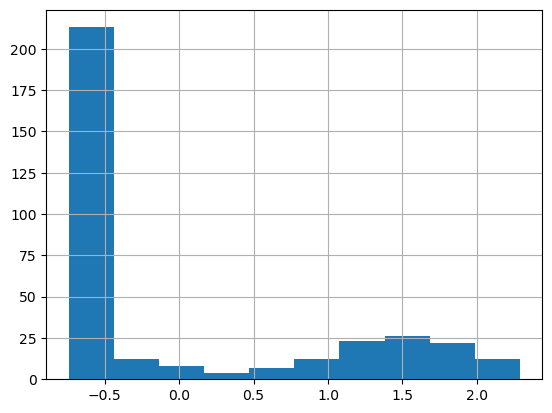

In [8]:
((df["Dogleg"]-df["Dogleg"].mean()) / df["Dogleg"].std()).hist()

In [9]:
df_dict = collections.defaultdict(list)
df_dict_val = collections.defaultdict(list)
df_target_cols = {}
df_target_cols_val = {}
train_folders = ['moldabek2737', "aktobe120","gran78"]
val_folders = ["balgimbayev245"]
types = [
    "ves_na_kru", 
    "effect_na", 
    "moment", 
    "min_ves"
]

print("--- TRAIN ---")
for folder in train_folders:
    print(folder)
    for type_name in types:
        if folder == "gran78" and type_name == "min_ves":
            print(f"\t Skipping {type_name} for {folder}")
            continue
        print("\t", type_name)
        df = pd.read_csv(f"../data/preprocessed/{folder}/{folder}_X.csv")
        y_ves = pd.read_csv(f"../data/preprocessed/{folder}/{folder}_Y_{type_name}.csv")
        
        if type_name == "effect_na":
            y_ves = y_ves.rename({"Глубина по стволу" : "MD"}, axis=1)
            y_ves = y_ves.drop_duplicates(subset='MD', keep='first')
        else:
            y_ves = y_ves.rename({"Измеренная глубина рейса" : "MD"}, axis=1)
        
        # Remove commas and convert to float if needed
        if y_ves["MD"].dtype == object:
            y_ves["MD"] = y_ves["MD"].str.replace(',', '').astype('float64')
        else:
            y_ves["MD"] = y_ves["MD"].astype('float64')
        
        target_cols = list(set(y_ves.columns) - set(["MD"]))

        merge_ves = pd.merge_asof(df, y_ves, on="MD")
        df_dict[type_name].append(merge_ves)
        df_target_cols[type_name] = target_cols

print("\n\n--- VALIDATION ---")

for folder in val_folders:
    print(folder)
    for type_name in types:
        print("\t", type_name)
        df = pd.read_csv(f"../data/preprocessed/{folder}/{folder}_X.csv")
        y_ves = pd.read_csv(f"../data/preprocessed/{folder}/{folder}_Y_{type_name}.csv")
        
        if type_name == "effect_na":
            y_ves = y_ves.rename({"Глубина по стволу" : "MD"}, axis=1)
            y_ves = y_ves.drop_duplicates(subset='MD', keep='first')
        else:
            y_ves = y_ves.rename({"Измеренная глубина рейса" : "MD"}, axis=1)
                
        target_cols = list(set(y_ves.columns) - set(["MD"]))
        merge_ves = pd.merge_asof(df, y_ves, on="MD")
        df_dict_val[type_name].append(merge_ves)
        df_target_cols_val[type_name] = target_cols


--- TRAIN ---
moldabek2737
	 ves_na_kru
	 effect_na
	 moment
	 min_ves
aktobe120
	 ves_na_kru
	 effect_na
	 moment
	 min_ves
gran78
	 ves_na_kru
	 effect_na
	 moment
	 Skipping min_ves for gran78


--- VALIDATION ---
balgimbayev245
	 ves_na_kru
	 effect_na
	 moment
	 min_ves


In [10]:
df_dict

defaultdict(list,
            {'ves_na_kru': [         MD   Incl.  Azim.  Sub-Sea      TVD  Local N Coord  Local E Coord  \
              0     0.000   0.000  0.000  -76.517    0.000          0.000          0.000   
              1    40.000   0.000  0.000  -36.517   40.000          0.000          0.000   
              2    50.000   0.833  0.349  -26.517   50.000          0.073          0.000   
              3    60.000   1.667  0.349  -16.520   59.997          0.291          0.002   
              4    70.000   2.500  0.349   -6.526   69.990          0.654          0.004   
              ..      ...     ...    ...      ...      ...            ...            ...   
              75  730.000  90.000  0.850  276.483  353.000        480.782          5.859   
              76  740.000  90.000  0.850  276.483  353.000        490.781          6.007   
              77  750.000  90.000  0.850  276.483  353.000        500.780          6.156   
              78  760.000  90.000  0.850  276.48

In [11]:
pd.concat(df_dict["min_ves"])[df_target_cols["min_ves"]]

,Мин. вес на долоте до спирального изгиба (бурение ГЗД),Мин. вес на долоте до синусоидального изгиба (бурение ротором),Мин. вес на долоте до синусоидального изгиба (бурение ГЗД),Мин. вес на долоте до спирального изгиба (бурение ротором)
0,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN
...,...,...,...,...
334,4.11,11.56,3.17,12.32
335,4.11,11.56,3.17,12.32
336,2.89,10.66,2.06,10.94
337,2.89,10.66,2.06,10.94


In [12]:
concanted_df = {}
for type_name in types:
    # Concatenate DataFrames
    temp = pd.concat(df_dict[type_name])
    
    # Sort the concatenated DataFrame by "MD"
    temp = temp.sort_values("MD")
    
    # Drop rows with missing values in the target columns
    temp = temp.dropna(subset=df_target_cols[type_name])
    
    # Store the cleaned DataFrame
    concanted_df[type_name] = temp


In [13]:
concanted_df

{'ves_na_kru':            MD   Incl.  Azim.   Sub-Sea       TVD  Local N Coord  \
 29    300.000  44.737   0.35   206.366   282.883         71.197   
 30    304.738  46.000   0.35   209.695   286.211         74.568   
 31    310.000  46.263   0.35   213.341   289.858         78.362   
 32    320.000  46.763   0.35   220.223   296.740         85.617   
 33    324.738  47.000   0.35   223.461   299.978         89.075   
 ..        ...     ...    ...       ...       ...            ...   
 334  2890.000  90.000  20.11  2243.739  2226.371        763.522   
 335  2900.000  90.000  20.11  2243.739  2226.371        772.912   
 336  2910.000  90.000  20.11  2243.739  2226.371        782.302   
 337  2920.000  90.000  20.11  2243.739  2226.371        791.693   
 338  2927.227  90.000  20.11  2243.739  2226.371        798.479   
 
      Local E Coord  Global N Coord  Global E Coord  Dogleg  ...  Weight  \
 29           0.434     5291133.987    1.028502e+07     8.0  ...   25.12   
 30           0.

In [14]:
concanted_df["effect_na"]["Грузоподъёмность вышки"].isna().sum()

0

In [15]:
df_dict["effect_na"][1]["Грузоподъёмность вышки"].isna().sum()

0

In [16]:
df_dict

defaultdict(list,
            {'ves_na_kru': [         MD   Incl.  Azim.  Sub-Sea      TVD  Local N Coord  Local E Coord  \
              0     0.000   0.000  0.000  -76.517    0.000          0.000          0.000   
              1    40.000   0.000  0.000  -36.517   40.000          0.000          0.000   
              2    50.000   0.833  0.349  -26.517   50.000          0.073          0.000   
              3    60.000   1.667  0.349  -16.520   59.997          0.291          0.002   
              4    70.000   2.500  0.349   -6.526   69.990          0.654          0.004   
              ..      ...     ...    ...      ...      ...            ...            ...   
              75  730.000  90.000  0.850  276.483  353.000        480.782          5.859   
              76  740.000  90.000  0.850  276.483  353.000        490.781          6.007   
              77  750.000  90.000  0.850  276.483  353.000        500.780          6.156   
              78  760.000  90.000  0.850  276.48

In [17]:
concanted_df

{'ves_na_kru':            MD   Incl.  Azim.   Sub-Sea       TVD  Local N Coord  \
 29    300.000  44.737   0.35   206.366   282.883         71.197   
 30    304.738  46.000   0.35   209.695   286.211         74.568   
 31    310.000  46.263   0.35   213.341   289.858         78.362   
 32    320.000  46.763   0.35   220.223   296.740         85.617   
 33    324.738  47.000   0.35   223.461   299.978         89.075   
 ..        ...     ...    ...       ...       ...            ...   
 334  2890.000  90.000  20.11  2243.739  2226.371        763.522   
 335  2900.000  90.000  20.11  2243.739  2226.371        772.912   
 336  2910.000  90.000  20.11  2243.739  2226.371        782.302   
 337  2920.000  90.000  20.11  2243.739  2226.371        791.693   
 338  2927.227  90.000  20.11  2243.739  2226.371        798.479   
 
      Local E Coord  Global N Coord  Global E Coord  Dogleg  ...  Weight  \
 29           0.434     5291133.987    1.028502e+07     8.0  ...   25.12   
 30           0.

<Axes: >

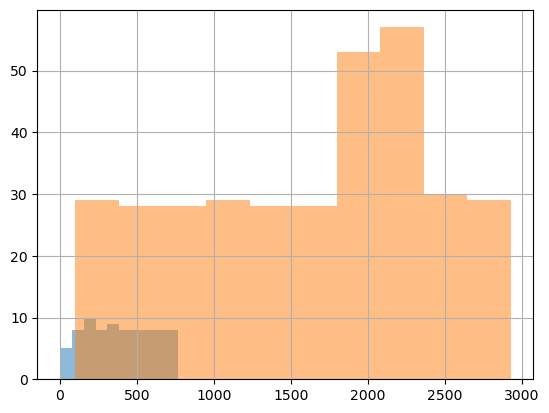

In [18]:
df_dict[type_name][0]["MD"].hist(alpha=.5)
df_dict[type_name][1]["MD"].hist(alpha=.5)
# df_dict_val[type_name][0]["MD"].hist(alpha=.5)

In [19]:
types

['ves_na_kru', 'effect_na', 'moment', 'min_ves']

In [20]:
df_target_cols

{'ves_na_kru': ['Макс. вес до предела текучести (подъём)',
  'Подъём',
  'Бурение ГЗД',
  'Мин. вес до спирального изгиба (спуск)',
  'Грузоподъёмность вышки',
  'Бурение ротором',
  'Спуск'],
 'effect_na': ['Спиральный изгиб(с вращением)',
  'Подъём',
  'Спиральный изгиб(без вращения)',
  'Синусоидальный изгиб(все операции)',
  'Глубина по вертикали',
  'Бурение ГЗД',
  'Грузоподъёмность вышки',
  'Предел натяжения',
  'Бурение ротором',
  'Спуск'],
 'moment': ['Подъём',
  ' Make-up Torque',
  'Бурение ротором',
  'Спуск',
  'Момент свинчивания'],
 'min_ves': ['Мин. вес на долоте до спирального изгиба (бурение ГЗД)',
  'Мин. вес на долоте до синусоидального изгиба (бурение ротором)',
  'Мин. вес на долоте до синусоидального изгиба (бурение ГЗД)',
  'Мин. вес на долоте до спирального изгиба (бурение ротором)']}

In [21]:
import numpy as np
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the current type for processing
current_type = "ves_na_kru"

# Extract the relevant data from the dataframe
X = concanted_df[current_type]
x_target_cols = df_target_cols[current_type]

# Separate the target columns
y = X[x_target_cols]
X = X.drop(x_target_cols, axis=1)

# Assign training data
X_train, y_train = X, y

# Assign test data
X_test = df_dict_val[current_type][0].drop(df_target_cols_val[current_type], axis=1)
y_test = df_dict_val[current_type][0][df_target_cols_val[current_type]]

# Feature engineering function
def add_features(df):
    df["sin_Incl."] = np.sin(df["Incl."])
    df["cos_Incl."] = np.cos(df["Incl."])
    df["tan_Incl."] = np.tan(df["Incl."])
    
    df["sin_Azim."] = np.sin(df["Azim."])
    df["cos_Azim."] = np.cos(df["Azim."])
    df["tan_Azim."] = np.tan(df["Azim."])
    
    df["Local_polar_angle"] = np.arctan2(df["Local N Coord"], df["Local E Coord"])
    df["Local_polar_r"] = np.sqrt(df["Local N Coord"]**2 + df["Local E Coord"]**2)
    
    df["Global_polar_angle"] = np.arctan2(df["Global N Coord"], df["Global E Coord"])
    df["Global_polar_r"] = np.sqrt(df["Global N Coord"]**2 + df["Global E Coord"]**2)
    return df

# Apply feature engineering to both training and test data
X_train = add_features(X_train)
X_test = add_features(X_test)

print(set(X_train.columns)- set(X_test.columns))
# Initialize scalers for feature scaling
x_scaler, y_scaler = StandardScaler(), StandardScaler()


# Scale the training data
X_train_scaled = x_scaler.fit_transform(X_train)
y_train_scaled = y_scaler.fit_transform(y_train)

# Scale the test data
X_test_scaled = x_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test)

# Output the shape of the scaled training data and the test data
print(X_train_scaled.shape, y_train_scaled.shape)
print(X_test_scaled.shape, y_test_scaled.shape)



set()
(214, 30) (214, 7)
(43, 30) (43, 7)


In [22]:
X_train

,MD,Incl.,Azim.,Sub-Sea,TVD,Local N Coord,Local E Coord,Global N Coord,Global E Coord,Dogleg,...,sin_Incl.,cos_Incl.,tan_Incl.,sin_Azim.,cos_Azim.,tan_Azim.,Local_polar_angle,Local_polar_r,Global_polar_angle,Global_polar_r
29,300.000,44.737,0.35,206.366,282.883,71.197,0.434,5291133.987,1.028502e+07,8.0,...,0.685072,0.728475,0.940420,0.342898,0.939373,0.365028,1.564701,71.198323,0.475141,1.156623e+07
30,304.738,46.000,0.35,209.695,286.211,74.568,0.455,5291137.358,1.028502e+07,8.0,...,0.901788,-0.432178,-2.086614,0.342898,0.939373,0.365028,1.564695,74.569388,0.475141,1.156623e+07
31,310.000,46.263,0.35,213.341,289.858,78.362,0.478,5291141.152,1.028502e+07,1.5,...,0.758423,-0.651763,-1.163648,0.342898,0.939373,0.365028,1.564697,78.363458,0.475142,1.156624e+07
32,320.000,46.763,0.35,220.223,296.740,85.617,0.522,5291148.407,1.028502e+07,1.5,...,0.353107,-0.935583,-0.377419,0.342898,0.939373,0.365028,1.564699,85.618591,0.475142,1.156624e+07
33,324.738,47.000,0.35,223.461,299.978,89.075,0.544,5291151.865,1.028502e+07,1.5,...,0.123573,-0.992335,-0.124528,0.342898,0.939373,0.365028,1.564689,89.076661,0.475142,1.156624e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
334,2890.000,90.000,20.11,2243.739,2226.371,763.522,277.730,5090218.022,9.691701e+06,0.0,...,0.893997,-0.448074,-1.995200,0.952226,0.305394,3.118024,1.221926,812.465259,0.483615,1.094712e+07
335,2900.000,90.000,20.11,2243.739,2226.371,772.912,281.168,5090227.412,9.691705e+06,0.0,...,0.893997,-0.448074,-1.995200,0.952226,0.305394,3.118024,1.221901,822.464834,0.483615,1.094713e+07
336,2910.000,90.000,20.11,2243.739,2226.371,782.302,284.606,5090236.802,9.691708e+06,0.0,...,0.893997,-0.448074,-1.995200,0.952226,0.305394,3.118024,1.221876,832.464410,0.483616,1.094713e+07
337,2920.000,90.000,20.11,2243.739,2226.371,791.693,288.045,5090246.193,9.691712e+06,0.0,...,0.893997,-0.448074,-1.995200,0.952226,0.305394,3.118024,1.221851,842.465268,0.483617,1.094714e+07


In [23]:
X_test.shape

(43, 30)

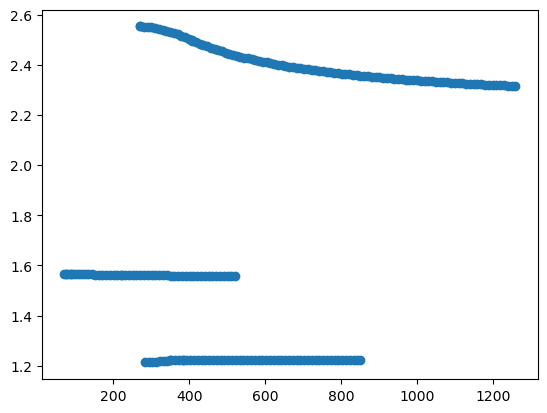

In [24]:
plt.scatter(X["Local_polar_r"], X["Local_polar_angle"])

In [25]:
X_train.to_csv('X_train.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

In [26]:
X_test_scaled

array([[-1.69187213, -9.7484039 , -1.033063  , ..., -1.95969285,
         0.87432463, -0.69865541],
       [-1.29711151, -9.7484039 , -1.033063  , ..., -1.95969285,
         0.87432463, -0.69865541],
       [-1.26122418, -9.18274068,  0.56742741, ..., -1.95528739,
         0.87432579, -0.69865986],
       ...,
       [-0.22049162,  0.35272502,  0.56742741, ...,  0.39372687,
         0.87494297, -0.70103077],
       [-0.18460429,  0.35272502,  0.56742741, ...,  0.49392506,
         0.87496929, -0.7011319 ],
       [-0.15941258,  0.35272502,  0.56742741, ...,  0.56426369,
         0.87498778, -0.70120289]])

In [27]:
y_train.isna().sum()

Макс. вес до предела текучести (подъём)    0
Подъём                                     0
Бурение ГЗД                                0
Мин. вес до спирального изгиба (спуск)     0
Грузоподъёмность вышки                     0
Бурение ротором                            0
Спуск                                      0
dtype: int64

In [28]:
y_train

,Макс. вес до предела текучести (подъём),Подъём,Бурение ГЗД,Мин. вес до спирального изгиба (спуск),Грузоподъёмность вышки,Бурение ротором,Спуск
29,86.26,24.07,20.34,17.00,225.0,18.30,22.57
30,86.26,24.07,20.34,17.00,225.0,18.30,22.57
31,93.18,24.24,20.41,17.00,225.0,18.41,22.63
32,88.38,24.33,20.42,17.00,225.0,18.46,22.64
33,88.38,24.33,20.42,17.00,225.0,18.46,22.64
...,...,...,...,...,...,...,...
334,133.19,76.43,52.45,50.91,225.0,59.57,55.66
335,133.19,76.43,52.45,50.91,225.0,59.57,55.66
336,132.62,76.60,51.71,51.11,225.0,59.36,54.95
337,132.62,76.60,51.71,51.11,225.0,59.36,54.95


In [29]:
X_train.isna().sum()

MD                         0
Incl.                      0
Azim.                      0
Sub-Sea                    0
TVD                        0
Local N Coord              0
Local E Coord              0
Global N Coord             0
Global E Coord             0
Dogleg                     0
Vertical Section           0
Body_OD                    0
Body_ID                    0
Body_AvgJointLength        0
Stabilizer_Length          0
Stabilizer_OD              0
Stabilizer_ID              0
Weight                     0
Coefficient of Friction    0
Minimum Yield Stress       0
sin_Incl.                  0
cos_Incl.                  0
tan_Incl.                  0
sin_Azim.                  0
cos_Azim.                  0
tan_Azim.                  0
Local_polar_angle          0
Local_polar_r              0
Global_polar_angle         0
Global_polar_r             0
dtype: int64

## `Multilayer Perceptron`

In [30]:
model = tf.keras.Sequential([
    layers.BatchNormalization(),
    layers.Dense(64, activation="relu", kernel_regularizer='l2', bias_regularizer='l2'),
    layers.Dense(48, activation="relu", kernel_regularizer='l2', bias_regularizer='l2'),
    layers.Dense(len(x_target_cols))
])
# model.summary()

In [31]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=keras.losses.Huber())

In [32]:
%%time
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    epochs=4,
    batch_size=32,
    # Suppress logging.
    verbose=2,
    shuffle=False,
#     callbacks = [keras.callbacks.EarlyStopping(monitor='loss', patience=3)],
    # Calculate validation results on 20% of the training data.
    validation_split = 0.33)


Epoch 1/4

5/5 - 1s - loss: 1.0231 - val_loss: 2.1458 - 1s/epoch - 293ms/step
Epoch 2/4
5/5 - 0s - loss: 0.6692 - val_loss: 1.7285 - 95ms/epoch - 19ms/step
Epoch 3/4
5/5 - 0s - loss: 0.4134 - val_loss: 1.4914 - 50ms/epoch - 10ms/step
Epoch 4/4
5/5 - 0s - loss: 0.2661 - val_loss: 1.4390 - 40ms/epoch - 8ms/step
CPU times: total: 1.75 s
Wall time: 1.77 s


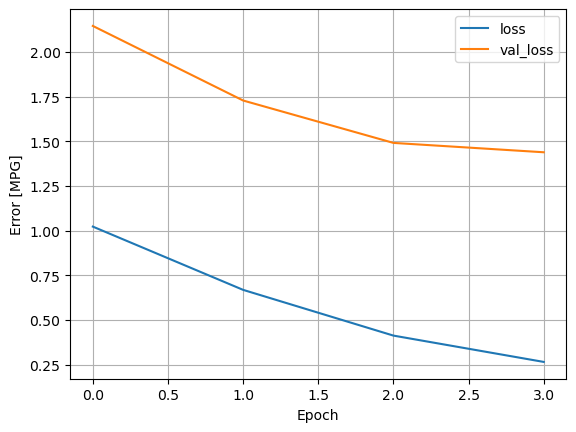

In [33]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)
plot_loss(history)

In [34]:
ff = pd.DataFrame(y_scaler.inverse_transform(model.predict(x_scaler.transform(X_test))), columns=y_test.columns)
# ff[y_test.reset_index()["is_train"]==1.0]["is_train"].hist(density=True)
# ff[y_test.reset_index()["is_train"]==0.0]["is_train"].hist(density=True)

2/2 [==============================] - 0s 2ms/step


In [35]:
diff = ff - y_test.reset_index(drop=True)
abs(diff).sum() / np.where(y_test.reset_index(drop=True).sum() == 0, 1, y_test.reset_index(drop=True).sum())

Макс. вес до предела текучести (подъём)    0.113635
Подъём                                     0.420109
Бурение ГЗД                                0.480773
Мин. вес до спирального изгиба (спуск)     0.395122
Грузоподъёмность вышки                     0.000474
Бурение ротором                            0.652721
Спуск                                      0.442968
dtype: float64

## `XBGoost Regressor`

In [36]:
import xgboost as xgb
reg = xgb.XGBRegressor(n_estimators=100, 
                       colsample_bynode=0.8,
                       max_depth=6,
                       tree_method="hist",
                       subsample=0.9,
                       min_child_weight=2,
                       multi_strategy="multi_output_tree")
reg = MultiOutputRegressor(LGBMRegressor(verbose=-1, subsample=0.7, subsample_freq=2))
reg.fit(X, y)

MultiOutputRegressor(estimator=LGBMRegressor(subsample=0.7, subsample_freq=2,
                                             verbose=-1))

In [37]:
predictions = pd.DataFrame(reg.predict(X_test), columns=y.columns)

In [38]:
diff = predictions - y_test.reset_index(drop=True)
abs(diff).sum() / np.where(y_test.reset_index(drop=True).sum() == 0, 1, y_test.reset_index(drop=True).sum())

Макс. вес до предела текучести (подъём)    0.036395
Подъём                                     0.120471
Бурение ГЗД                                0.059975
Мин. вес до спирального изгиба (спуск)     0.057474
Грузоподъёмность вышки                     0.000000
Бурение ротором                            0.211620
Спуск                                      0.151991
dtype: float64

In [39]:
predictions

,Макс. вес до предела текучести (подъём),Подъём,Бурение ГЗД,Мин. вес до спирального изгиба (спуск),Грузоподъёмность вышки,Бурение ротором,Спуск
0,92.954262,28.724787,24.159235,20.115924,225.0,20.944082,24.161402
1,92.954262,28.724787,24.159235,20.115924,225.0,20.944082,24.161402
2,96.647770,29.555055,23.556730,20.448841,225.0,20.874256,23.719929
3,95.914605,29.576362,23.556730,20.448841,225.0,20.911298,23.796677
4,96.428029,29.555055,23.068803,20.450931,225.0,20.583246,23.170762
5,96.363661,29.475007,24.452604,20.453850,225.0,20.755205,24.941705
6,96.659219,29.700994,23.020856,20.571512,225.0,20.280039,22.994883
7,96.393361,29.612443,23.499204,20.551734,225.0,20.868828,23.351571
8,95.847306,29.633749,23.499204,20.511181,225.0,20.889833,23.458478
9,96.360730,29.612443,23.499204,20.511181,225.0,20.766448,23.458478


## `Multilayer Perceptron + XGBoost Regressor`

In [97]:
import numpy as np
from sklearn.base import BaseEstimator
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, BatchNormalization
from xgboost import XGBRegressor


class MultiOutputStackingRegressor(BaseEstimator):
    def __init__(self, nn_epochs=4, nn_batch_size=32):
        self.nn_epochs = nn_epochs
        self.nn_batch_size = nn_batch_size
        self.nn_model = None
        self.xgb_model = None
    
    def fit(self, X, y):
        # Step 1: Split data into folds for cross-validation
        kf = KFold(n_splits=3, shuffle=False)
        xgb_inputs = []
        xgb_targets = []
        
        # Step 2: Train Keras neural network and collect predictions
        nn_preds = np.empty_like(y)
        for train_index, val_index in kf.split(X):
            X_train, X_val = X[train_index], X[val_index]
            y_train, y_val = y[train_index], y[val_index]
            
            # Train Keras neural network
            nn_model = self._train_keras_nn(X_train, y_train)
            
            # Predict using Keras neural network
            nn_pred = nn_model.predict(X_val)
            nn_preds[val_index] = nn_pred
            
            # Collect inputs and targets for XGBoost training
            xgb_inputs.append(np.concatenate((X_val, nn_pred), axis=1))
            xgb_targets.append(y_val)
        
        # Step 3: Train XGBoost regressor on combined dataset
        combined_xgb_input = np.concatenate(xgb_inputs)
        combined_xgb_target = np.concatenate(xgb_targets)
        self.xgb_model = self._train_xgboost(combined_xgb_input, combined_xgb_target)
        
        # Step 4: Train neural network on entire dataset
        self.nn_model = self._train_keras_nn(X, y)
    
    def predict(self, X):
        # Step 1: Predict using neural network
        nn_preds = self.nn_model.predict(X)
        
        # Step 2: Combine predictions with original input dataset
        xgb_input = np.concatenate((X, nn_preds), axis=1)

        # Step 3: Predict using XGBoost regressor
        return self.xgb_model.predict(xgb_input)
    
    def _train_keras_nn(self, X, y):
        input_shape = X.shape[1]
        output_shape = y.shape[1]
        
        model = Sequential()
        model.add(BatchNormalization())
        model.add(Dense(64, input_shape=(input_shape,), activation="relu", kernel_regularizer='l1', bias_regularizer='l1'))
        model.add(Dense(48, activation='relu', kernel_regularizer='l1', bias_regularizer='l1'))
        model.add(Dense(output_shape, activation=None))  # No activation for regression
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
            loss=keras.losses.Huber()
        )
        
        model.fit(X, y, epochs=self.nn_epochs, batch_size=self.nn_batch_size, verbose=0, shuffle=False)
        return model
    
    def _train_xgboost(self, X, y):
        xgb = XGBRegressor(n_estimators=100, 
                       colsample_bytree=0.5,
                       max_depth=5,
                       tree_method="hist",
                       subsample=1.0,
                       reg_lambda=1e-03,
                       min_child_weight=3,
                       multi_strategy="multi_output_tree")
        # xgb = MultiOutputRegressor(LGBMRegressor(verbose=-1, subsample=0.7, subsample_freq=2))
        xgb.fit(X, y)
        return xgb


In [41]:
model = MultiOutputStackingRegressor()
model.fit(X_train_scaled, y_train_scaled)

3/3 [==============================] - 0s 1ms/step


In [42]:
X_test.shape

(43, 30)

In [43]:
predictions = pd.DataFrame(y_scaler.inverse_transform(model.predict(x_scaler.transform(X_test))), columns=y.columns)
diff = predictions - y_test.reset_index(drop=True)
abs(diff).sum() / np.where(y_test.reset_index(drop=True).sum() == 0, 1, y_test.reset_index(drop=True).sum())

2/2 [==============================] - 0s 4ms/step


Макс. вес до предела текучести (подъём)    0.046934
Подъём                                     0.115203
Бурение ГЗД                                0.250186
Мин. вес до спирального изгиба (спуск)     0.135499
Грузоподъёмность вышки                     0.000000
Бурение ротором                            0.248690
Спуск                                      0.256068
dtype: float64

In [44]:
predictions = pd.DataFrame(y_scaler.inverse_transform(model.predict(x_scaler.transform(X_test))), columns=y.columns)
diff = predictions - y_test.reset_index(drop=True)
abs(diff).sum() / (y_test.reset_index(drop=True).sum().abs())

2/2 [==============================] - 0s 2ms/step


Макс. вес до предела текучести (подъём)    0.046934
Подъём                                     0.115203
Бурение ГЗД                                0.250186
Мин. вес до спирального изгиба (спуск)     0.135499
Грузоподъёмность вышки                     0.000000
Бурение ротором                            0.248690
Спуск                                      0.256068
dtype: float64

In [45]:
df_dict_val['ves_na_kru']

[          MD   Incl.  Azim.  Sub-Sea      TVD  Local N Coord  Local E Coord  \
 0      0.000   0.000    0.0   21.760    0.000          0.000          0.000   
 1    330.000   0.000    0.0  351.760  330.000          0.000          0.000   
 2    360.000   5.040  248.0  381.722  359.961         -0.494         -1.223   
 3    390.000  10.080  248.0  411.451  389.691         -1.972         -4.881   
 4    420.000  15.120  248.0  440.720  418.959         -4.423        -10.947   
 5    450.000  20.160  248.0  469.300  447.539         -7.827        -19.373   
 6    480.000  25.200  248.0  496.971  475.210        -12.159        -30.095   
 7    510.000  30.240  248.0  523.519  501.759        -17.385        -43.029   
 8    540.000  35.280  248.0  548.740  526.979        -23.464        -58.076   
 9    570.000  40.320  248.0  572.437  550.676        -30.350        -75.119   
 10   580.000  42.000  248.0  579.965  558.205        -32.815        -81.221   
 11   600.000  42.000  248.0  594.828  5

In [46]:
types

['ves_na_kru', 'effect_na', 'moment', 'min_ves']

In [47]:
concanted_df

{'ves_na_kru':            MD   Incl.  Azim.   Sub-Sea       TVD  Local N Coord  \
 29    300.000  44.737   0.35   206.366   282.883         71.197   
 30    304.738  46.000   0.35   209.695   286.211         74.568   
 31    310.000  46.263   0.35   213.341   289.858         78.362   
 32    320.000  46.763   0.35   220.223   296.740         85.617   
 33    324.738  47.000   0.35   223.461   299.978         89.075   
 ..        ...     ...    ...       ...       ...            ...   
 334  2890.000  90.000  20.11  2243.739  2226.371        763.522   
 335  2900.000  90.000  20.11  2243.739  2226.371        772.912   
 336  2910.000  90.000  20.11  2243.739  2226.371        782.302   
 337  2920.000  90.000  20.11  2243.739  2226.371        791.693   
 338  2927.227  90.000  20.11  2243.739  2226.371        798.479   
 
      Local E Coord  Global N Coord  Global E Coord  Dogleg  ...  Weight  \
 29           0.434     5291133.987    1.028502e+07     8.0  ...   25.12   
 30           0.

In [48]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define the function to process a given type and return the WMAPE dataframe
def calculate_wmape(current_type):
    # Extract the relevant data from the dataframe
    X = concanted_df[current_type]
    x_target_cols = df_target_cols[current_type]

    # Separate the target columns
    y = X[x_target_cols]
    X = X.drop(x_target_cols, axis=1)

    # Assign training data
    X_train, y_train = X, y

    # Assign test data
    X_test = df_dict_val[current_type][0].drop(df_target_cols_val[current_type], axis=1)
    y_test = df_dict_val[current_type][0][df_target_cols_val[current_type]]

    # Feature engineering function
    def add_features(df):
        df["sin_Incl."] = np.sin(df["Incl."])
        df["cos_Incl."] = np.cos(df["Incl."])
        df["tan_Incl."] = np.tan(df["Incl."])
        
        df["sin_Azim."] = np.sin(df["Azim."])
        df["cos_Azim."] = np.cos(df["Azim."])
        df["tan_Azim."] = np.tan(df["Azim."])
        
        df["Local_polar_angle"] = np.arctan2(df["Local N Coord"], df["Local E Coord"])
        df["Local_polar_r"] = np.sqrt(df["Local N Coord"]**2 + df["Local E Coord"]**2)
        
        df["Global_polar_angle"] = np.arctan2(df["Global N Coord"], df["Global E Coord"])
        df["Global_polar_r"] = np.sqrt(df["Global N Coord"]**2 + df["Global E Coord"]**2)
        return df

    # Apply feature engineering to both training and test data
    X_train = add_features(X_train)
    X_test = add_features(X_test)

    # Initialize scalers for feature scaling
    x_scaler, y_scaler = StandardScaler(), StandardScaler()

    # Scale the training data
    X_train_scaled = x_scaler.fit_transform(X_train)
    y_train_scaled = y_scaler.fit_transform(y_train)

    # Scale the test data
    X_test_scaled = x_scaler.transform(X_test)
    y_test_scaled = y_scaler.transform(y_test)

    # Define and train the model
    model = MultiOutputStackingRegressor()
    model.fit(X_train_scaled, y_train_scaled)

    # Make predictions and calculate WMAPE
    predictions = pd.DataFrame(y_scaler.inverse_transform(model.predict(X_test_scaled)), columns=y.columns)
    diff = predictions - y_test.reset_index(drop=True)
    wmape = abs(diff).sum() / np.where(y_test.reset_index(drop=True).sum().abs() == 0, 1, y_test.reset_index(drop=True).sum().abs())
    
    # Add the current type to the WMAPE dataframe
    wmape_df = wmape.reset_index().rename(columns={0: 'wmape'})
    wmape_df['type'] = current_type

    return wmape_df


# Initialize an empty list to store WMAPE dataframes
wmape_dfs = []

# Traverse through types and calculate WMAPE for each type
for current_type in types:
    wmape_df = calculate_wmape(current_type)
    wmape_dfs.append(wmape_df)

# Concatenate all WMAPE dataframes
concatenated_wmape_df = pd.concat(wmape_dfs, ignore_index=True)

# Export the concatenated dataframe to a CSV file
concatenated_wmape_df.to_csv('wmape_summary.csv', index=False)

print("WMAPE summary has been exported to 'wmape_summary.csv'.")


2/2 [==============================] - 0s 2ms/step
WMAPE summary has been exported to 'wmape_summary.csv'.


In [49]:
df_dict_val_new = {}
for type_name in types:
    # Concatenate DataFrames
    temp = pd.concat(df_dict_val[type_name])
    
    # Drop rows with missing values in the target columns
    temp = temp.dropna(subset=df_target_cols[type_name])
    
    # Store the cleaned DataFrame
    df_dict_val_new[type_name] = temp


In [50]:
# Combine concanted_df and df_dict_val_new into one dataframe
df_combined = {}
for type_name in types:
    df_combined[type_name] = pd.concat([concanted_df[type_name], df_dict_val_new[type_name]], ignore_index=True)

In [51]:
df_combined

{'ves_na_kru':            MD   Incl.   Azim.  Sub-Sea      TVD  Local N Coord  Local E Coord  \
 0     300.000  44.737    0.35  206.366  282.883         71.197          0.434   
 1     304.738  46.000    0.35  209.695  286.211         74.568          0.455   
 2     310.000  46.263    0.35  213.341  289.858         78.362          0.478   
 3     320.000  46.763    0.35  220.223  296.740         85.617          0.522   
 4     324.738  47.000    0.35  223.461  299.978         89.075          0.544   
 ..        ...     ...     ...      ...      ...            ...            ...   
 229  1170.000  90.000  248.00  681.280  659.520       -241.478       -597.678   
 230  1200.000  90.000  248.00  681.280  659.520       -252.716       -625.493   
 231  1230.000  90.000  248.00  681.280  659.520       -263.954       -653.309   
 232  1260.000  90.000  248.00  681.280  659.520       -275.192       -681.124   
 233  1281.059  90.000  248.00  681.280  659.520       -283.081       -700.650   
 


In [114]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import joblib


# Define the function to process a given type and return the WMAPE dataframe
def calculate_wmape(current_type):
    # Extract the relevant data from the dataframe
    X = df_combined[current_type]
    x_target_cols = df_target_cols[current_type]
    if current_type == 'effect_na':
        X = X[X['Бурение ГЗД'] <= 10]
        X = X[X['Предел натяжения'] <= 200]
        
    # Separate the target columns
    y = X[x_target_cols]
    X = X.drop(x_target_cols, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


    # Feature engineering function
    def add_features(df):
        df["sin_Incl."] = np.sin(df["Incl."])
        df["cos_Incl."] = np.cos(df["Incl."])
        df["tan_Incl."] = np.tan(df["Incl."])
        
        df["sin_Azim."] = np.sin(df["Azim."])
        df["cos_Azim."] = np.cos(df["Azim."])
        df["tan_Azim."] = np.tan(df["Azim."])
        
        df["Local_polar_angle"] = np.arctan2(df["Local N Coord"], df["Local E Coord"])
        df["Local_polar_r"] = np.sqrt(df["Local N Coord"]**2 + df["Local E Coord"]**2)
        
        df["Global_polar_angle"] = np.arctan2(df["Global N Coord"], df["Global E Coord"])
        df["Global_polar_r"] = np.sqrt(df["Global N Coord"]**2 + df["Global E Coord"]**2)
        return df

    # Apply feature engineering to both training and test data
    X_train = add_features(X_train)
    X_test = add_features(X_test)

    # Initialize scalers for feature scaling
    x_scaler, y_scaler = StandardScaler(), StandardScaler()

    # Scale the training data
    X_train_scaled = x_scaler.fit_transform(X_train)
    y_train_scaled = y_scaler.fit_transform(y_train)

    # Scale the test data
    X_test_scaled = x_scaler.transform(X_test)
    y_test_scaled = y_scaler.transform(y_test)

    # Define and train the model
    model = MultiOutputStackingRegressor()
    model.fit(X_train_scaled, y_train_scaled)

    # Save the model and scalers with names corresponding to the current type
    model_name = f'model_{current_type}.joblib'
    x_scaler_name = f'x_scaler_{current_type}.joblib'
    y_scaler_name = f'y_scaler_{current_type}.joblib'
    
    joblib.dump(model, model_name)
    joblib.dump(x_scaler, x_scaler_name)
    joblib.dump(y_scaler, y_scaler_name)

    print(f"Model and scalers for type '{current_type}' have been saved.")

    # Make predictions and calculate WMAPE
    predictions = pd.DataFrame(y_scaler.inverse_transform(model.predict(X_test_scaled)), columns=y.columns)
    diff = predictions - y_test.reset_index(drop=True)
    wmape = abs(diff).sum() / np.where(y_test.reset_index(drop=True).sum().abs() == 0, 1, y_test.reset_index(drop=True).sum().abs())
    
    # Add the current type to the WMAPE dataframe
    wmape_df = wmape.reset_index().rename(columns={0: 'wmape'})
    wmape_df['type'] = current_type

    return wmape_df


# Initialize an empty list to store WMAPE dataframes
wmape_dfs = []

# Traverse through types and calculate WMAPE for each type
for current_type in types:
    wmape_df = calculate_wmape(current_type)
    wmape_dfs.append(wmape_df)

# Concatenate all WMAPE dataframes
concatenated_wmape_df = pd.concat(wmape_dfs, ignore_index=True)

# Export the concatenated dataframe to a CSV file
concatenated_wmape_df.to_csv('wmape_summary.csv', index=False)

print("WMAPE summary has been exported to 'wmape_summary.csv'.")


2/2 [==============================] - 0s 2ms/step
Model and scalers for type 'ves_na_kru' have been saved.
4/4 [==============================] - 0s 2ms/step
Model and scalers for type 'effect_na' have been saved.
2/2 [==============================] - 0s 3ms/step
Model and scalers for type 'moment' have been saved.
2/2 [==============================] - 0s 2ms/step
Model and scalers for type 'min_ves' have been saved.
1/1 [==============================] - 0s 81ms/step
WMAPE summary has been exported to 'wmape_summary.csv'.


In [115]:
concatenated_wmape_df

,index,wmape,type
0,Макс. вес до предела текучести (подъём),0.007553,ves_na_kru
1,Подъём,0.003859,ves_na_kru
2,Бурение ГЗД,0.007454,ves_na_kru
3,Мин. вес до спирального изгиба (спуск),0.012316,ves_na_kru
4,Грузоподъёмность вышки,0.000000,ves_na_kru
5,Бурение ротором,0.003600,ves_na_kru
6,Спуск,0.006827,ves_na_kru
7,Спиральный изгиб(с вращением),0.141985,effect_na
8,Подъём,0.065693,effect_na
9,Спиральный изгиб(без вращения),0.141980,effect_na


In [116]:
concatenated_wmape_df['wmape%'] = concatenated_wmape_df['wmape'].apply(lambda x: '{:.2f}%'.format(x * 100))

In [117]:
concatenated_wmape_df

,index,wmape,type,wmape%
0,Макс. вес до предела текучести (подъём),0.007553,ves_na_kru,0.76%
1,Подъём,0.003859,ves_na_kru,0.39%
2,Бурение ГЗД,0.007454,ves_na_kru,0.75%
3,Мин. вес до спирального изгиба (спуск),0.012316,ves_na_kru,1.23%
4,Грузоподъёмность вышки,0.000000,ves_na_kru,0.00%
5,Бурение ротором,0.003600,ves_na_kru,0.36%
6,Спуск,0.006827,ves_na_kru,0.68%
7,Спиральный изгиб(с вращением),0.141985,effect_na,14.20%
8,Подъём,0.065693,effect_na,6.57%
9,Спиральный изгиб(без вращения),0.141980,effect_na,14.20%


In [56]:
df_experimant = df_combined['effect_na']

In [57]:
df_combined['ves_na_kru'].head()

,MD,Incl.,Azim.,Sub-Sea,TVD,Local N Coord,Local E Coord,Global N Coord,Global E Coord,Dogleg,...,Weight,Coefficient of Friction,Minimum Yield Stress,Спуск,Подъём,Бурение ротором,Бурение ГЗД,Мин. вес до спирального изгиба (спуск),Макс. вес до предела текучести (подъём),Грузоподъёмность вышки
0,300.000,44.737,0.35,206.366,282.883,71.197,0.434,5291133.987,1.028502e+07,8.0,...,25.12,0.25,105,22.57,24.07,18.30,20.34,17.0,86.26,225.0
1,304.738,46.000,0.35,209.695,286.211,74.568,0.455,5291137.358,1.028502e+07,8.0,...,25.12,0.25,105,22.57,24.07,18.30,20.34,17.0,86.26,225.0
2,310.000,46.263,0.35,213.341,289.858,78.362,0.478,5291141.152,1.028502e+07,1.5,...,25.12,0.25,105,22.63,24.24,18.41,20.41,17.0,93.18,225.0
3,320.000,46.763,0.35,220.223,296.740,85.617,0.522,5291148.407,1.028502e+07,1.5,...,25.12,0.25,105,22.64,24.33,18.46,20.42,17.0,88.38,225.0
4,324.738,47.000,0.35,223.461,299.978,89.075,0.544,5291151.865,1.028502e+07,1.5,...,25.12,0.25,105,22.64,24.33,18.46,20.42,17.0,88.38,225.0


In [58]:
df_experimant = df_experimant[df_experimant['Бурение ГЗД'] <= 10]

In [59]:
df_experimant = df_experimant[df_experimant['Предел натяжения'] <= 200]

In [60]:
df_experimant.info

<bound method DataFrame.info of          MD   Incl.    Azim.  Sub-Sea      TVD  Local N Coord  Local E Coord  \
0       0.0   0.000    0.000  -76.517    0.000          0.000          0.000   
1       0.0   0.000    0.000   17.490    0.000          0.000          0.000   
2      40.0   0.000    0.000  -36.517   40.000          0.000          0.000   
3      50.0   0.833    0.349  -26.517   50.000          0.073          0.000   
4      60.0   1.667    0.349  -16.520   59.997          0.291          0.002   
..      ...     ...      ...      ...      ...            ...            ...   
607  1110.0  90.000  248.000  681.280  659.520       -219.001       -542.047   
608  1140.0  90.000  248.000  681.280  659.520       -230.239       -569.862   
609  1170.0  90.000  248.000  681.280  659.520       -241.478       -597.678   
610  1200.0  90.000  248.000  681.280  659.520       -252.716       -625.493   
611  1230.0  90.000  248.000  681.280  659.520       -263.954       -653.309   

     Gl

In [61]:
X = df_experimant
x_target_cols = df_target_cols['effect_na']

# Separate the target columns
y = X[x_target_cols]
X = X.drop(x_target_cols, axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Feature engineering function
def add_features(df):
    df["sin_Incl."] = np.sin(df["Incl."])
    df["cos_Incl."] = np.cos(df["Incl."])
    df["tan_Incl."] = np.tan(df["Incl."])
        
    df["sin_Azim."] = np.sin(df["Azim."])
    df["cos_Azim."] = np.cos(df["Azim."])
    df["tan_Azim."] = np.tan(df["Azim."])
        
    df["Local_polar_angle"] = np.arctan2(df["Local N Coord"], df["Local E Coord"])
    df["Local_polar_r"] = np.sqrt(df["Local N Coord"]**2 + df["Local E Coord"]**2)
        
    df["Global_polar_angle"] = np.arctan2(df["Global N Coord"], df["Global E Coord"])
    df["Global_polar_r"] = np.sqrt(df["Global N Coord"]**2 + df["Global E Coord"]**2)
    return df

    # Apply feature engineering to both training and test data
X_train = add_features(X_train)
X_test = add_features(X_test)

# Initialize scalers for feature scaling
x_scaler, y_scaler = StandardScaler(), StandardScaler()

# Scale the training data
X_train_scaled = x_scaler.fit_transform(X_train)
y_train_scaled = y_scaler.fit_transform(y_train)

# Scale the test data
X_test_scaled = x_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test)

# Define and train the model
model = MultiOutputStackingRegressor()
model.fit(X_train_scaled, y_train_scaled)

# Make predictions and calculate WMAPE
predictions = pd.DataFrame(y_scaler.inverse_transform(model.predict(X_test_scaled)), columns=y.columns)
diff = predictions - y_test.reset_index(drop=True)
wmape = abs(diff).sum() / np.where(y_test.reset_index(drop=True).sum().abs() == 0, 1, y_test.reset_index(drop=True).sum().abs())
    
# Add the current type to the WMAPE dataframe
wmape_df = wmape.reset_index().rename(columns={0: 'wmape'})
wmape_df['type'] = 'effect_na'

print(wmape_df)


3/3 [==============================] - 0s 2ms/step
                                index     wmape       type
0       Спиральный изгиб(с вращением)  0.166505  effect_na
1                              Подъём  0.090581  effect_na
2      Спиральный изгиб(без вращения)  0.166520  effect_na
3  Синусоидальный изгиб(все операции)  0.166521  effect_na
4                Глубина по вертикали  0.066721  effect_na
5                         Бурение ГЗД  0.080843  effect_na
6              Грузоподъёмность вышки  0.000000  effect_na
7                    Предел натяжения  0.008779  effect_na
8                     Бурение ротором  0.120389  effect_na
9                               Спуск  0.159671  effect_na


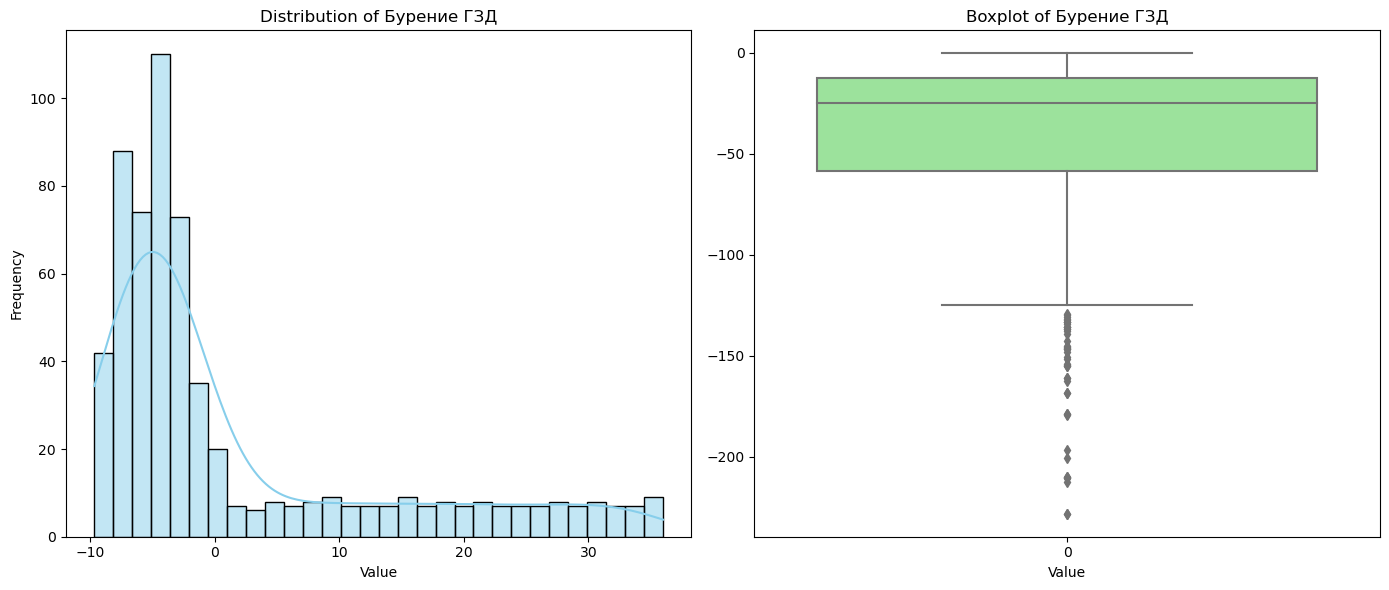

In [62]:
# Plotting the histogram and boxplot
plt.figure(figsize=(14, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(data = df_combined['effect_na']['Бурение ГЗД'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Бурение ГЗД')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(data = df_combined['effect_na']['Спиральный изгиб(с вращением)'], color='lightgreen')
plt.title('Boxplot of Бурение ГЗД')
plt.xlabel('Value')

plt.tight_layout()
plt.show()

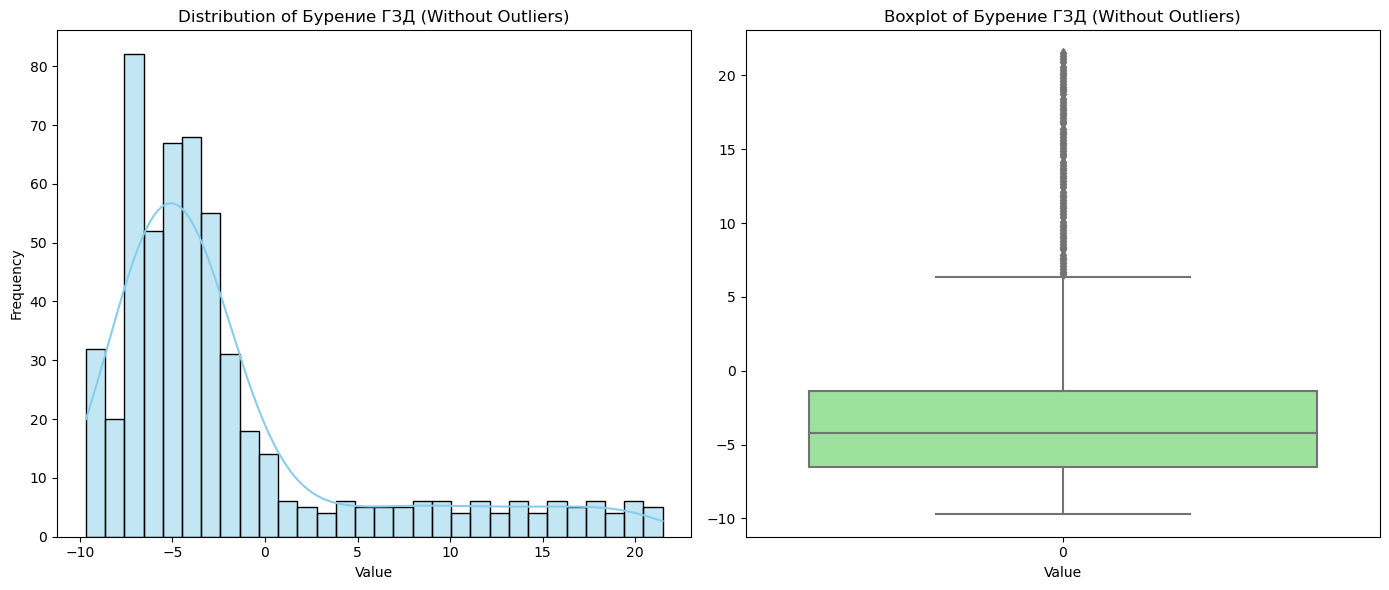

In [63]:
# Removing outliers using the IQR method
Q1 = df_combined['effect_na']['Бурение ГЗД'].quantile(0.25)
Q3 = df_combined['effect_na']['Бурение ГЗД'].quantile(0.75)
IQR = Q3 - Q1

# Filtering out outliers
data_filtered = df_combined['effect_na']['Бурение ГЗД'][(df_combined['effect_na']['Бурение ГЗД'] >= (Q1 - 1.5 * IQR)) & (df_combined['effect_na']['Бурение ГЗД'] <= (Q3 + 1.5 * IQR))]

# Plotting the distribution and boxplot after removing outliers
plt.figure(figsize=(14, 6))

# Histogram
plt.subplot(1, 2, 1)
sns.histplot(data_filtered, bins=30, kde=True, color='skyblue')
plt.title('Distribution of Бурение ГЗД (Without Outliers)')
plt.xlabel('Value')
plt.ylabel('Frequency')

# Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(data_filtered, color='lightgreen')
plt.title('Boxplot of Бурение ГЗД (Without Outliers)')
plt.xlabel('Value')

plt.tight_layout()
plt.show()


In [64]:
data_filtered

0      0.58
1     -2.03
2     -0.22
3     -0.42
4     -0.62
       ... 
609   -3.36
610   -3.09
611   -2.87
612   -2.51
613   -2.12
Name: Бурение ГЗД, Length: 543, dtype: float64

In [65]:
df_target_cols['effect_na']

['Спиральный изгиб(с вращением)',
 'Подъём',
 'Спиральный изгиб(без вращения)',
 'Синусоидальный изгиб(все операции)',
 'Глубина по вертикали',
 'Бурение ГЗД',
 'Грузоподъёмность вышки',
 'Предел натяжения',
 'Бурение ротором',
 'Спуск']

# Visualizations

In [118]:
X = pd.read_csv("../data/preprocessed/aktobe120/aktobe120_X.csv")
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 339 entries, 0 to 338
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   MD                       339 non-null    float64
 1   Incl.                    339 non-null    float64
 2   Azim.                    339 non-null    float64
 3   Sub-Sea                  339 non-null    float64
 4   TVD                      339 non-null    float64
 5   Local N Coord            339 non-null    float64
 6   Local E Coord            339 non-null    float64
 7   Global N Coord           339 non-null    float64
 8   Global E Coord           339 non-null    float64
 9   Dogleg                   339 non-null    float64
 10  Vertical Section         339 non-null    float64
 11  Body_OD                  339 non-null    float64
 12  Body_ID                  339 non-null    float64
 13  Body_AvgJointLength      339 non-null    float64
 14  Stabilizer_Length        3

## Вес на крюке

In [336]:
Y_ves = pd.read_csv("../data/preprocessed/aktobe120/aktobe120_Y_ves_na_kru.csv")
Y_ves = Y_ves.rename({"Измеренная глубина рейса" : "MD"}, axis=1)
# Y_ves["MD"] = Y_ves["MD"].str.replace(",", "").astype(float)
Y_ves.head(5)

,MD,Спуск,Подъём,Бурение ротором,Бурение ГЗД,Мин. вес до спирального изгиба (спуск),Макс. вес до предела текучести (подъём),Грузоподъёмность вышки
0,2359,59.80,71.92,59.40,57.01,52.06,132.07,225
1,2409,59.19,72.11,59.23,56.10,54.22,131.98,225
2,2459,58.40,72.72,59.14,55.26,53.84,132.81,225
3,2509,58.14,72.85,59.13,54.93,53.56,132.74,225
4,2559,58.86,74.26,60.09,55.76,53.61,132.29,225


In [337]:
target_cols = list(set(Y_ves.columns) - set(["MD"]))
Y_ves.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 8 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   MD                                       13 non-null     int64  
 1   Спуск                                    13 non-null     float64
 2   Подъём                                   13 non-null     float64
 3   Бурение ротором                          13 non-null     float64
 4   Бурение ГЗД                              13 non-null     float64
 5   Мин. вес до спирального изгиба (спуск)   13 non-null     float64
 6   Макс. вес до предела текучести (подъём)  13 non-null     float64
 7   Грузоподъёмность вышки                   13 non-null     int64  
dtypes: float64(6), int64(2)
memory usage: 964.0 bytes


In [338]:
X_ves = X[(X["MD"] >= Y_ves["MD"].min()) & (X["MD"] <= Y_ves["MD"].max())]
X_ves.head()

,MD,Incl.,Azim.,Sub-Sea,TVD,Local N Coord,Local E Coord,Global N Coord,Global E Coord,Dogleg,Vertical Section,Body_OD,Body_ID,Body_AvgJointLength,Stabilizer_Length,Stabilizer_OD,Stabilizer_ID,Weight,Coefficient of Friction,Minimum Yield Stress
279,2360.0,79.072,19.082,2237.354,2219.986,265.024,99.122,5089719.524,9691522.812,5.0,282.94,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
280,2370.0,80.699,18.712,2239.110,2221.742,274.338,102.310,5089728.838,9691526.000,5.0,292.79,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
281,2380.0,82.326,18.346,2240.586,2223.218,283.716,105.453,5089738.216,9691529.143,5.0,302.67,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
282,2390.0,83.953,17.982,2241.781,2224.412,293.149,108.548,5089747.649,9691532.238,5.0,312.60,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
283,2400.0,85.580,17.621,2242.693,2225.325,302.630,111.592,5089757.130,9691535.282,5.0,322.55,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105


In [339]:
X_ves["MD"] = X_ves["MD"].astype(int)
Y_ves["MD"] = Y_ves["MD"].astype(int)
df = pd.merge_asof(X_ves, Y_ves, on="MD", direction="nearest")
df.head()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16480\1022974934.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_ves["MD"] = X_ves["MD"].astype(int)


,MD,Incl.,Azim.,Sub-Sea,TVD,Local N Coord,Local E Coord,Global N Coord,Global E Coord,Dogleg,...,Weight,Coefficient of Friction,Minimum Yield Stress,Спуск,Подъём,Бурение ротором,Бурение ГЗД,Мин. вес до спирального изгиба (спуск),Макс. вес до предела текучести (подъём),Грузоподъёмность вышки
0,2360,79.072,19.082,2237.354,2219.986,265.024,99.122,5089719.524,9691522.812,5.0,...,25.12,0.3,105,59.80,71.92,59.40,57.01,52.06,132.07,225
1,2370,80.699,18.712,2239.110,2221.742,274.338,102.310,5089728.838,9691526.000,5.0,...,25.12,0.3,105,59.80,71.92,59.40,57.01,52.06,132.07,225
2,2380,82.326,18.346,2240.586,2223.218,283.716,105.453,5089738.216,9691529.143,5.0,...,25.12,0.3,105,59.80,71.92,59.40,57.01,52.06,132.07,225
3,2390,83.953,17.982,2241.781,2224.412,293.149,108.548,5089747.649,9691532.238,5.0,...,25.12,0.3,105,59.19,72.11,59.23,56.10,54.22,131.98,225
4,2400,85.580,17.621,2242.693,2225.325,302.630,111.592,5089757.130,9691535.282,5.0,...,25.12,0.3,105,59.19,72.11,59.23,56.10,54.22,131.98,225


In [340]:
y_full = df[target_cols]
X_full = df.drop(target_cols, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full,test_size=.5,shuffle=False)
X_train.shape, X_test.shape

((30, 20), (30, 20))

In [341]:
# Apply feature engineering to both training and test data
X_test = add_features(X_test)

# Load the saved model and scalers for 'ves_na_kru'
model_path = './model_ves_na_kru.joblib'
x_scaler_path = './x_scaler_ves_na_kru.joblib'
y_scaler_path = './y_scaler_ves_na_kru.joblib'

model = joblib.load(model_path)
x_scaler = joblib.load(x_scaler_path)
y_scaler = joblib.load(y_scaler_path)

# Scale the test data
X_test_scaled = x_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test)

# Make predictions and calculate WMAPE
predictions = pd.DataFrame(y_scaler.inverse_transform(model.predict(X_test_scaled)), columns=y_test.columns)

1/1 [==============================] - 0s 77ms/step


In [342]:
predictions_df = pd.DataFrame(predictions, columns=target_cols)
predictions_df

,Макс. вес до предела текучести (подъём),Подъём,Бурение ГЗД,Мин. вес до спирального изгиба (спуск),Грузоподъёмность вышки,Бурение ротором,Спуск
0,133.084854,74.974274,55.015167,53.274090,225.0,60.068748,58.127567
1,133.084854,74.974274,55.015167,53.274090,225.0,60.068748,58.127567
2,133.001877,75.045433,54.674179,53.531551,225.0,59.989471,57.814449
3,133.001877,75.045433,54.674179,53.531551,225.0,59.989471,57.814449
4,133.001877,75.045433,54.674179,53.531551,225.0,59.989471,57.814449
5,133.001877,75.045433,54.674179,53.531551,225.0,59.989471,57.814449
6,133.001877,75.045433,54.674179,53.531551,225.0,59.989471,57.814449
7,132.906540,75.565262,54.068821,53.395588,225.0,59.916012,57.256783
8,132.909805,75.601654,54.032532,53.353512,225.0,59.910767,57.222179
9,132.909805,75.601654,54.032532,53.353512,225.0,59.910767,57.222179


In [343]:
y_test

,Макс. вес до предела текучести (подъём),Подъём,Бурение ГЗД,Мин. вес до спирального изгиба (спуск),Грузоподъёмность вышки,Бурение ротором,Спуск
30,132.98,75.02,54.68,53.59,225,59.99,57.82
31,132.98,75.02,54.68,53.59,225,59.99,57.82
32,132.98,75.02,54.68,53.59,225,59.99,57.82
33,132.98,75.02,54.68,53.59,225,59.99,57.82
34,132.98,75.02,54.68,53.59,225,59.99,57.82
35,132.90,75.61,54.02,53.37,225,59.91,57.21
36,132.90,75.61,54.02,53.37,225,59.91,57.21
37,132.90,75.61,54.02,53.37,225,59.91,57.21
38,132.90,75.61,54.02,53.37,225,59.91,57.21
39,132.90,75.61,54.02,53.37,225,59.91,57.21


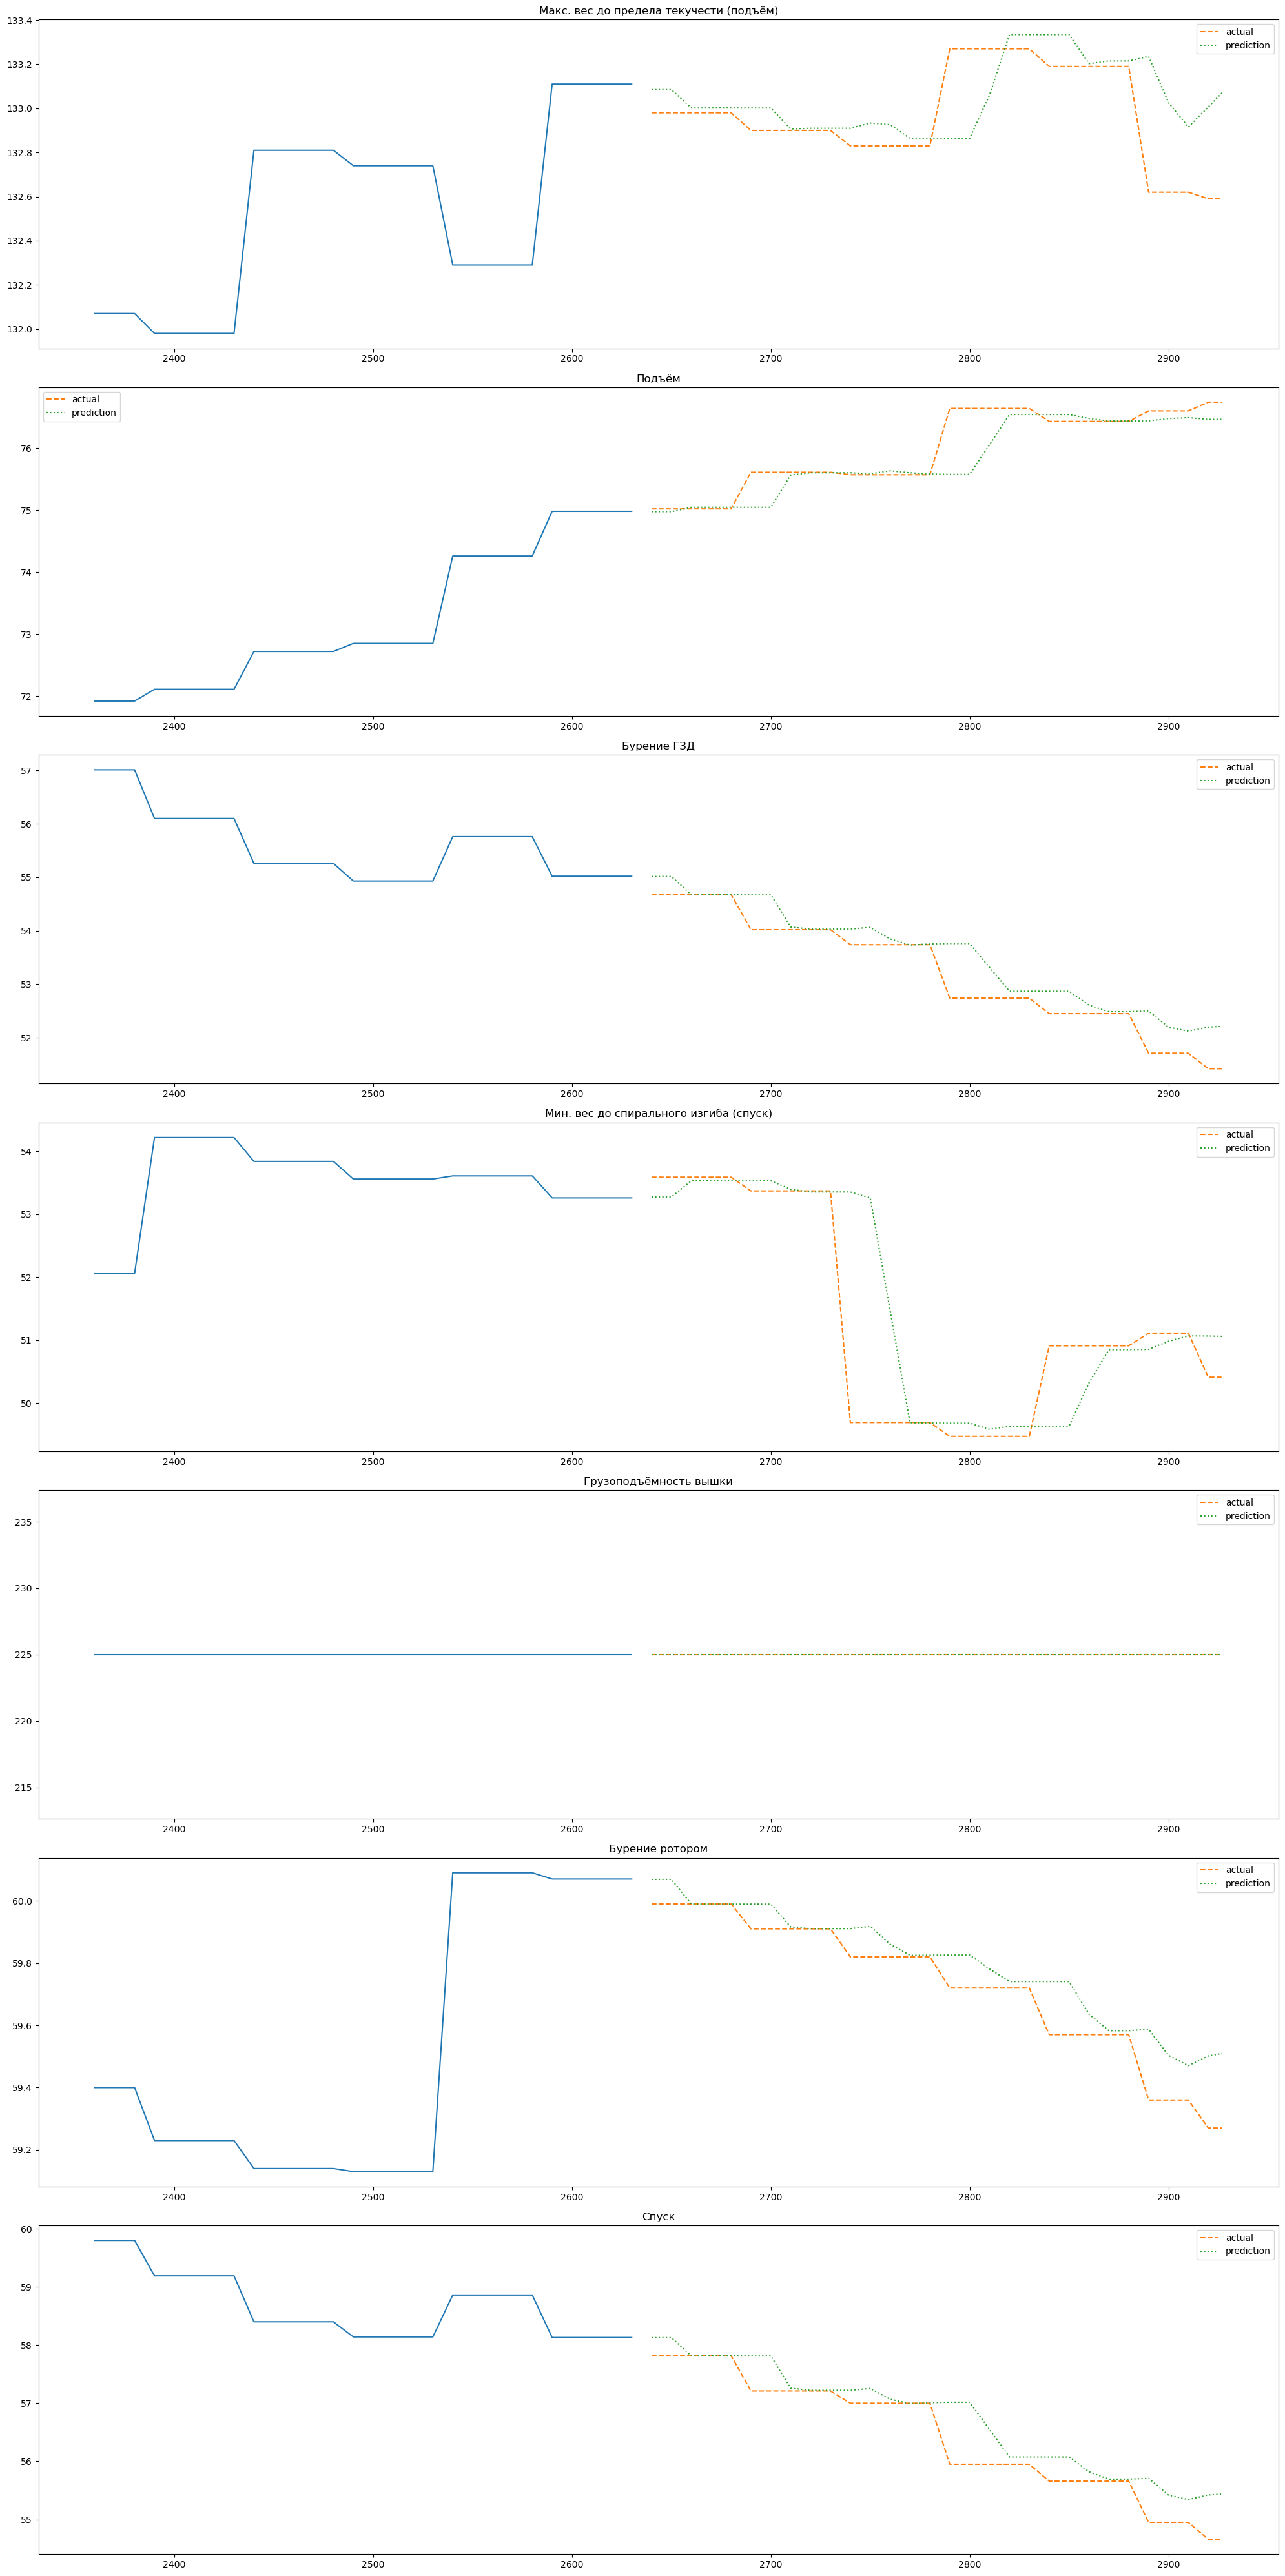

In [344]:
fig, ax = plt.subplots(len(target_cols), figsize=(20, 40))
for i, col in enumerate(target_cols):
    ax[i].set_title(col)
    ax[i].plot(X_train["MD"], y_train[col])
    ax[i].plot(X_test["MD"], y_test[col], label="actual",  linestyle='--')
    ax[i].plot(X_test["MD"], predictions_df[col], label="prediction", linestyle=':')
    ax[i].legend() 
plt.tight_layout()
plt.show()


In [345]:
y_test = y_test.reset_index().drop("index", axis=1)
mape = (abs(y_test - predictions_df) / (y_test+1e-8)).mean() * 100

print("MAPE Error in percents per column")
print(mape.to_frame())

MAPE Error in percents per column
                                                0
Макс. вес до предела текучести (подъём)  0.114573
Подъём                                   0.246984
Бурение ГЗД                              0.633627
Мин. вес до спирального изгиба (спуск)   1.065328
Грузоподъёмность вышки                   0.000000
Бурение ротором                          0.126718
Спуск                                    0.577755


['Макс. вес до предела текучести (подъём)', 'Подъём', 'Бурение ГЗД', 'Мин. вес до спирального изгиба (спуск)', 'Грузоподъёмность вышки', 'Бурение ротором', 'Спуск']


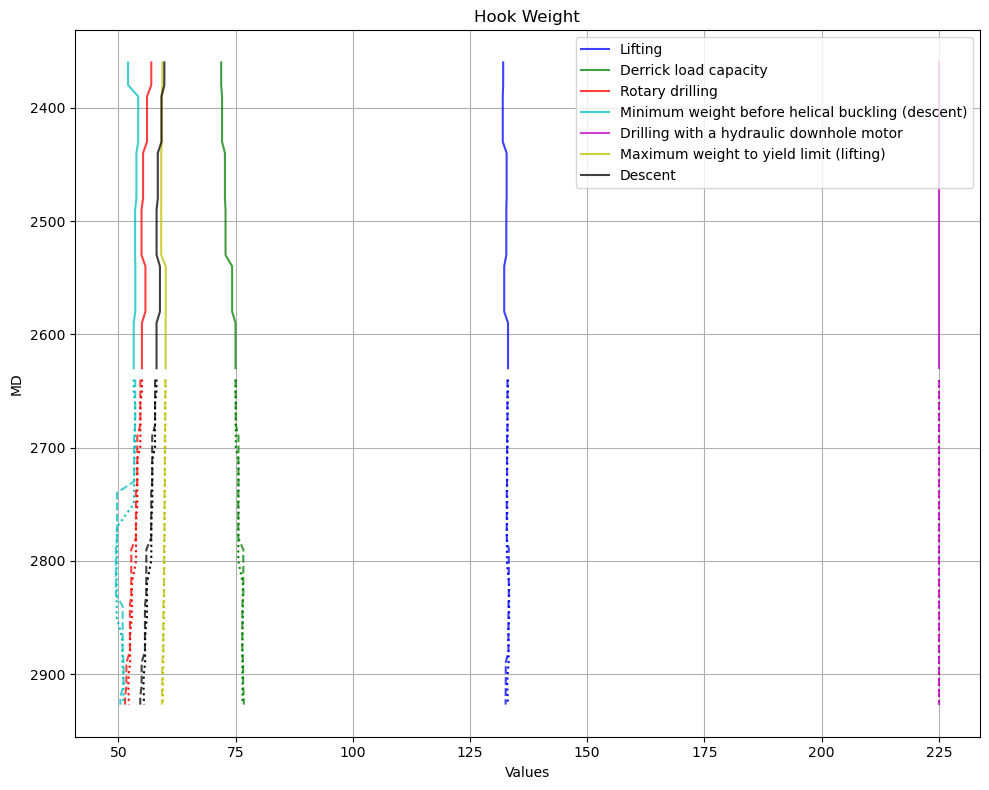

In [362]:
plt.figure(figsize=(10, 8))  # Set the figure size
color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FFA500']
target_cols_eng = ['Lifting', 'Derrick load capacity', 'Rotary drilling', 'Minimum weight before helical buckling (descent)', 'Drilling with a hydraulic downhole motor', 'Maximum weight to yield limit (lifting)', 'Descent']

for color, col_id in zip(color_list, range(len(target_cols))):
    col = target_cols[col_id]
    label = target_cols_eng[col_id]
    plt.plot( y_train[col], X_train["MD"], label=label, color=color, alpha=0.75)
    plt.plot( y_test[col],X_test["MD"], color=color, alpha=0.75, linestyle = '--')
    plt.plot( predictions_df[col],X_test["MD"], color=color, alpha=1.0, linestyle = ':')
# for col, color in zip(df.columns, colors):
#     plt.plot(df.index, df[col], label=col, color=color)
print(target_cols)
# ['Подъём', 'Грузоподъёмность вышки', 'Бурение ротором', 'Мин. вес до спирального изгиба (спуск)', 'Бурение ГЗД', 'Макс. вес до предела текучести (подъём)', 'Спуск']

# Add labels and title
plt.xlabel('Values')
plt.ylabel('MD')
plt.title('Hook Weight')

# Add legend
plt.legend()
plt.gca().invert_yaxis()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


## Момент

In [363]:
Y_ves = pd.read_csv("../data/preprocessed/aktobe120/aktobe120_Y_moment.csv")
Y_ves = Y_ves.rename({"Измеренная глубина рейса" : "MD"}, axis=1)
# Y_ves["MD"] = Y_ves["MD"].str.replace(",", "").astype(float)
Y_ves.head(5)

,MD,Спуск,Подъём,Бурение ротором,Момент свинчивания,Make-up Torque
0,2359,0,0,5.2360,18.3673,18.3673
1,2409,0,0,5.7066,18.3673,18.3673
2,2459,0,0,6.1398,18.3673,18.3673
3,2509,0,0,6.2523,18.3673,18.3673
4,2559,0,0,6.3393,18.3673,18.3673


In [364]:
target_cols = list(set(Y_ves.columns) - set(["MD"]))
Y_ves.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   MD                  13 non-null     int64  
 1   Спуск               13 non-null     int64  
 2   Подъём              13 non-null     int64  
 3   Бурение ротором     13 non-null     float64
 4   Момент свинчивания  13 non-null     float64
 5    Make-up Torque     13 non-null     float64
dtypes: float64(3), int64(3)
memory usage: 756.0 bytes


In [365]:
X_ves = X[(X["MD"] >= Y_ves["MD"].min()) & (X["MD"] <= Y_ves["MD"].max())]
X_ves.head()

,MD,Incl.,Azim.,Sub-Sea,TVD,Local N Coord,Local E Coord,Global N Coord,Global E Coord,Dogleg,Vertical Section,Body_OD,Body_ID,Body_AvgJointLength,Stabilizer_Length,Stabilizer_OD,Stabilizer_ID,Weight,Coefficient of Friction,Minimum Yield Stress
279,2360.0,79.072,19.082,2237.354,2219.986,265.024,99.122,5089719.524,9691522.812,5.0,282.94,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
280,2370.0,80.699,18.712,2239.110,2221.742,274.338,102.310,5089728.838,9691526.000,5.0,292.79,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
281,2380.0,82.326,18.346,2240.586,2223.218,283.716,105.453,5089738.216,9691529.143,5.0,302.67,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
282,2390.0,83.953,17.982,2241.781,2224.412,293.149,108.548,5089747.649,9691532.238,5.0,312.60,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
283,2400.0,85.580,17.621,2242.693,2225.325,302.630,111.592,5089757.130,9691535.282,5.0,322.55,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105


In [366]:
Y_ves["MD"] = Y_ves["MD"].astype(int)
X_ves["MD"] = X_ves["MD"].astype(int)
df = pd.merge_asof(X_ves, Y_ves, on="MD", direction="nearest")
df.head()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16480\1184738816.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_ves["MD"] = X_ves["MD"].astype(int)


,MD,Incl.,Azim.,Sub-Sea,TVD,Local N Coord,Local E Coord,Global N Coord,Global E Coord,Dogleg,...,Stabilizer_OD,Stabilizer_ID,Weight,Coefficient of Friction,Minimum Yield Stress,Спуск,Подъём,Бурение ротором,Момент свинчивания,Make-up Torque
0,2360,79.072,19.082,2237.354,2219.986,265.024,99.122,5089719.524,9691522.812,5.0,...,119.86,53.98,25.12,0.3,105,0,0,5.2360,18.3673,18.3673
1,2370,80.699,18.712,2239.110,2221.742,274.338,102.310,5089728.838,9691526.000,5.0,...,119.86,53.98,25.12,0.3,105,0,0,5.2360,18.3673,18.3673
2,2380,82.326,18.346,2240.586,2223.218,283.716,105.453,5089738.216,9691529.143,5.0,...,119.86,53.98,25.12,0.3,105,0,0,5.2360,18.3673,18.3673
3,2390,83.953,17.982,2241.781,2224.412,293.149,108.548,5089747.649,9691532.238,5.0,...,119.86,53.98,25.12,0.3,105,0,0,5.7066,18.3673,18.3673
4,2400,85.580,17.621,2242.693,2225.325,302.630,111.592,5089757.130,9691535.282,5.0,...,119.86,53.98,25.12,0.3,105,0,0,5.7066,18.3673,18.3673


In [367]:
y_full = df[target_cols]
X_full = df.drop(target_cols, axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full,test_size=.5,shuffle=False)
X_train.shape, X_test.shape

((30, 20), (30, 20))

In [368]:
# Apply feature engineering to both training and test data
X_test = add_features(X_test)

# Load the saved model and scalers for 'ves_na_kru'
model_path = './model_moment.joblib'
x_scaler_path = './x_scaler_moment.joblib'
y_scaler_path = './y_scaler_moment.joblib'

model = joblib.load(model_path)
x_scaler = joblib.load(x_scaler_path)
y_scaler = joblib.load(y_scaler_path)

# Scale the test data
X_test_scaled = x_scaler.transform(X_test)
y_test_scaled = y_scaler.transform(y_test)

# Make predictions and calculate WMAPE
predictions = pd.DataFrame(y_scaler.inverse_transform(model.predict(X_test_scaled)), columns=y_test.columns)

1/1 [==============================] - 0s 78ms/step


In [369]:
predictions

,Подъём,Make-up Torque,Бурение ротором,Спуск,Момент свинчивания
0,-0.000030,18.360207,6.751527,-0.000019,18.360207
1,-0.000030,18.360207,6.751527,-0.000019,18.360207
2,-0.000126,18.359819,6.871732,-0.000041,18.359819
3,-0.000126,18.359503,6.873695,-0.000041,18.359503
4,-0.000029,18.359953,6.875828,-0.000031,18.359953
5,-0.000049,18.360180,6.875426,-0.000046,18.360180
6,-0.000049,18.360180,6.875426,-0.000046,18.360180
7,-0.000047,18.360149,7.142740,-0.000023,18.360149
8,-0.000047,18.360149,7.142740,-0.000023,18.360149
9,-0.000057,18.360138,7.140821,-0.000065,18.360138


In [370]:
y_test

,Подъём,Make-up Torque,Бурение ротором,Спуск,Момент свинчивания
30,0,18.3673,6.8591,0,18.3673
31,0,18.3673,6.8591,0,18.3673
32,0,18.3673,6.8591,0,18.3673
33,0,18.3673,6.8591,0,18.3673
34,0,18.3673,6.8591,0,18.3673
35,0,18.3673,7.1449,0,18.3673
36,0,18.3673,7.1449,0,18.3673
37,0,18.3673,7.1449,0,18.3673
38,0,18.3673,7.1449,0,18.3673
39,0,18.3673,7.1449,0,18.3673


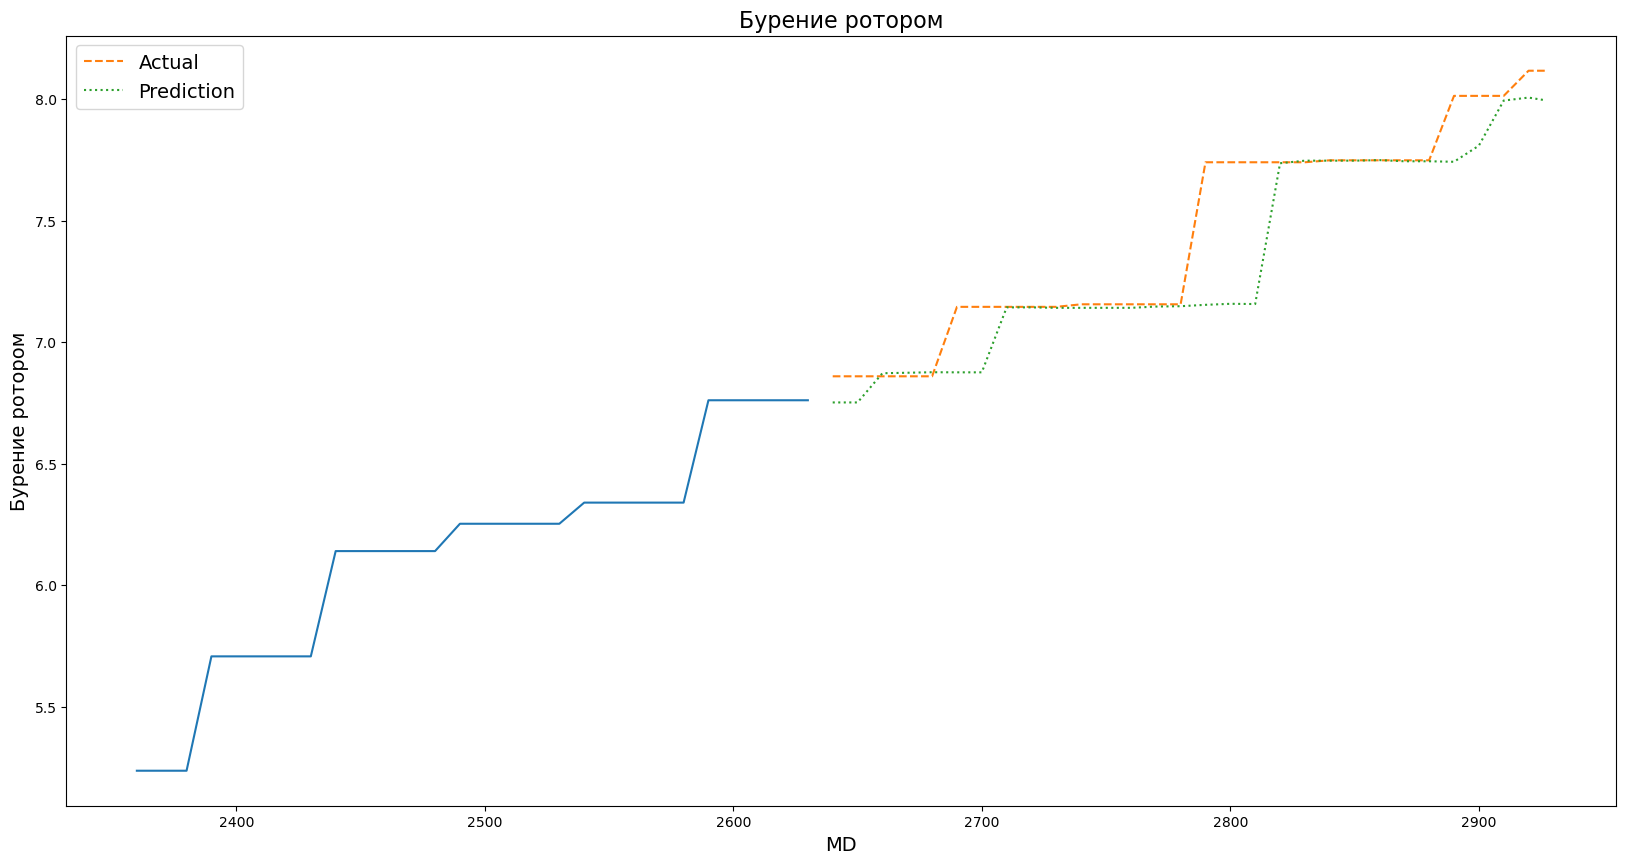

In [374]:
plt.figure(figsize=(20, 10))

plt.title('Бурение ротором', fontsize=16)

plt.plot(X_train["MD"], y_train['Бурение ротором'])

plt.plot(X_test["MD"], y_test['Бурение ротором'], label="Actual", linestyle='--')

plt.plot(X_test["MD"], predictions['Бурение ротором'], label="Prediction", linestyle=':')

plt.xlabel('MD', fontsize=14)
plt.ylabel('Бурение ротором', fontsize=14)
plt.legend(fontsize=14) 

plt.show()


In [334]:
y_test = y_test.reset_index().drop("index", axis=1)
mape = (abs(y_test - predictions) / (y_test+1e-8)).mean() * 100

print("MAPE Error in percents per column")
print(mape.to_frame())

MAPE Error in percents per column
                                0
Подъём              550989.257173
 Make-up Torque          0.027679
Бурение ротором          1.475635
Спуск               606736.541613
Момент свинчивания       0.027679


['Подъём', ' Make-up Torque', 'Бурение ротором', 'Спуск', 'Момент свинчивания']


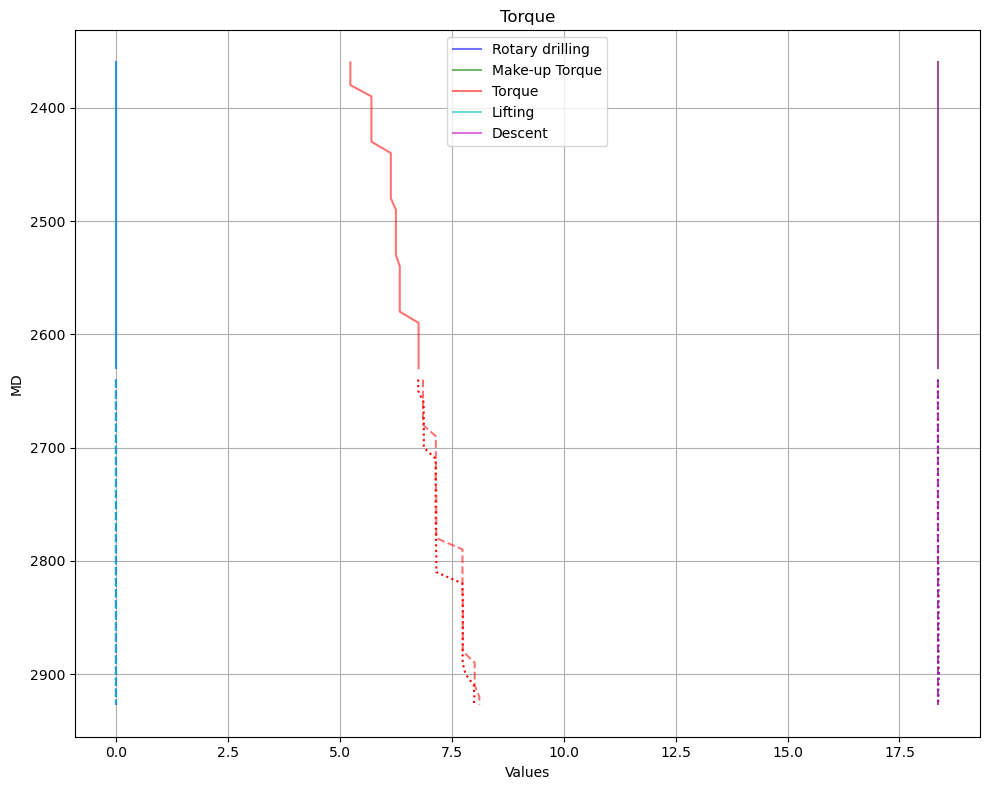

In [335]:
target_cols_eng = ['Rotary drilling', 'Make-up Torque', 'Torque', 'Lifting', 'Descent']

plt.figure(figsize=(10, 8))  # Set the figure size
color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FFA500']

for color, col_id in zip(color_list, range(len(target_cols))):
    col = target_cols[col_id]
    label = target_cols_eng[col_id]
    plt.plot( y_train[col], X_train["MD"], label=label, color=color, alpha=0.55)
    plt.plot( y_test[col], X_test["MD"], color=color, alpha=0.55, linestyle = '--')
    plt.plot( predictions[col], X_test["MD"], color=color, alpha=1.0, linestyle = ':')

print(target_cols)
# ['Бурение ротором', ' Make-up Torque', 'Момент свинчивания', 'Подъём', 'Спуск']

# Add labels and title
plt.xlabel('Values')
plt.ylabel('MD')
plt.title('Torque')

# Add legend
plt.legend()
plt.gca().invert_yaxis()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


## Эффект натяжения

In [375]:
Y_ves = pd.read_csv("../data/preprocessed/aktobe120/aktobe120_Y_effect_na.csv")
Y_ves = Y_ves.rename({"Глубина по стволу" : "MD"}, axis=1).drop("Глубина по вертикали", axis=1)
# Y_ves["MD"] = Y_ves["MD"].str.replace(",", "").astype(float)
Y_ves.head(5)

,MD,Спуск,Подъём,Бурение ротором,Бурение ГЗД,Синусоидальный изгиб(все операции),Спиральный изгиб(с вращением),Спиральный изгиб(без вращения),Предел натяжения,Грузоподъёмность вышки
0,0.00,41.11,63.80,45.75,37.98,-24.83,-35.12,-70.24,128.96,225
1,9.03,40.96,63.50,45.54,37.82,-10.94,-15.47,-30.94,128.96,225
2,18.06,40.78,63.26,45.33,37.64,-2.01,-2.84,-5.68,128.96,225
3,27.09,40.58,63.04,45.13,37.44,-14.17,-20.04,-40.09,128.96,225
4,36.13,40.43,62.75,44.92,37.29,-0.92,-1.31,-2.61,128.96,225


In [376]:
target_cols = list(set(Y_ves.columns) - set(["MD"]))
Y_ves.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 10 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   MD                                  344 non-null    float64
 1   Спуск                               344 non-null    float64
 2   Подъём                              344 non-null    float64
 3   Бурение ротором                     344 non-null    float64
 4   Бурение ГЗД                         344 non-null    float64
 5   Синусоидальный изгиб(все операции)  344 non-null    float64
 6   Спиральный изгиб(с вращением)       344 non-null    float64
 7   Спиральный изгиб(без вращения)      344 non-null    float64
 8   Предел натяжения                    344 non-null    float64
 9   Грузоподъёмность вышки              344 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 27.0 KB


In [377]:
X_ves = X[(X["MD"] >= Y_ves["MD"].min()) & (X["MD"] <= Y_ves["MD"].max())]
X_ves.head()

,MD,Incl.,Azim.,Sub-Sea,TVD,Local N Coord,Local E Coord,Global N Coord,Global E Coord,Dogleg,Vertical Section,Body_OD,Body_ID,Body_AvgJointLength,Stabilizer_Length,Stabilizer_OD,Stabilizer_ID,Weight,Coefficient of Friction,Minimum Yield Stress
0,100.0,0.300,108.180,117.368,100.000,-0.082,0.249,5089454.418,9691423.939,0.090,0.01,101.6,82.3,9.144,0.433,138.91,76.2,26.41,0.25,105
1,110.0,0.411,92.123,127.367,109.999,-0.091,0.309,5089454.409,9691423.999,0.445,0.02,101.6,82.3,9.144,0.433,138.91,76.2,26.41,0.25,105
2,120.0,0.360,88.348,137.367,119.999,-0.092,0.377,5089454.408,9691424.067,0.171,0.04,101.6,82.3,9.144,0.433,138.91,76.2,26.41,0.25,105
3,130.0,0.273,93.810,147.367,129.999,-0.092,0.432,5089454.408,9691424.122,0.275,0.06,101.6,82.3,9.144,0.433,138.91,76.2,26.41,0.25,105
4,140.0,0.263,104.222,157.367,139.999,-0.100,0.478,5089454.400,9691424.168,0.149,0.07,101.6,82.3,9.144,0.433,138.91,76.2,26.41,0.25,105


In [378]:
df = pd.merge_asof(X_ves, Y_ves, on="MD", direction="nearest")
df.head()

,MD,Incl.,Azim.,Sub-Sea,TVD,Local N Coord,Local E Coord,Global N Coord,Global E Coord,Dogleg,...,Minimum Yield Stress,Спуск,Подъём,Бурение ротором,Бурение ГЗД,Синусоидальный изгиб(все операции),Спиральный изгиб(с вращением),Спиральный изгиб(без вращения),Предел натяжения,Грузоподъёмность вышки
0,100.0,0.300,108.180,117.368,100.000,-0.082,0.249,5089454.418,9691423.939,0.090,...,105,39.14,61.07,43.48,35.99,-3.22,-4.55,-9.10,128.96,225
1,110.0,0.411,92.123,127.367,109.999,-0.091,0.309,5089454.409,9691423.999,0.445,...,105,38.95,60.83,43.27,35.80,-11.18,-15.81,-31.62,128.96,225
2,120.0,0.360,88.348,137.367,119.999,-0.092,0.377,5089454.408,9691424.067,0.171,...,105,38.79,60.56,43.07,35.63,-7.21,-10.19,-20.39,128.96,225
3,130.0,0.273,93.810,147.367,129.999,-0.092,0.432,5089454.408,9691424.122,0.275,...,105,38.61,60.31,42.86,35.45,-3.97,-5.61,-11.23,128.96,225
4,140.0,0.263,104.222,157.367,139.999,-0.100,0.478,5089454.400,9691424.168,0.149,...,105,38.24,59.84,42.45,35.07,-4.48,-6.34,-12.67,128.96,225


In [379]:
y_full = df[target_cols]
X_full = df.drop(target_cols, axis=1).fillna(method="ffill")
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full,test_size=.5,shuffle=False)
X_train.shape, X_test.shape

((169, 20), (170, 20))

In [380]:
# Apply feature engineering to both training and test data
X_test = add_features(X_test)

# Load the saved model and scalers for 'ves_na_kru'
model_path = './model_effect_na.joblib'
x_scaler_path = './x_scaler_effect_na.joblib'
y_scaler_path = './y_scaler_effect_na.joblib'

model = joblib.load(model_path)
x_scaler = joblib.load(x_scaler_path)
y_scaler = joblib.load(y_scaler_path)

# Scale the test data
X_test_scaled = x_scaler.transform(X_test)

# Make predictions and calculate WMAPE
predictions_df = pd.DataFrame(y_scaler.inverse_transform(model.predict(X_test_scaled)))

6/6 [==============================] - 0s 2ms/step


In [381]:
predictions_df

,0,1,2,3,4,5,6,7,8,9
0,-6.713097,18.383766,-13.428753,-4.745064,1794.483032,1.340487,225.0,127.426285,6.245143,4.972233
1,-10.105007,18.137142,-20.212894,-7.143303,1805.768677,1.129311,225.0,127.380959,6.020304,4.759104
2,-7.885296,17.875534,-15.774860,-5.574444,1815.111572,0.923045,225.0,127.380417,5.799287,4.555748
3,-7.280041,17.749249,-14.563557,-5.146727,1815.499878,0.801834,225.0,127.352020,5.685016,4.436958
4,-2.141796,17.319262,-4.285878,-1.513035,1838.823242,0.412041,225.0,127.360283,5.278798,4.046899
...,...,...,...,...,...,...,...,...,...,...
165,-21.395496,0.765941,-42.787971,-15.132606,2231.686523,-3.268244,225.0,127.361267,-5.989115,-0.759382
166,-23.586790,0.585347,-47.168758,-16.682108,2239.442627,-3.070931,225.0,127.871620,-6.011430,-0.573807
167,-18.912533,0.847573,-37.821041,-13.375125,2247.247559,-3.321310,225.0,127.711533,-6.045979,-0.847590
168,-18.746555,0.883253,-37.488495,-13.257985,2197.133057,-3.321344,225.0,127.027374,-6.012947,-0.859639


In [382]:
# Assuming 'df' is your DataFrame
new_column_names = [
    'Спиральный изгиб(с вращением)', 'Подъём', 'Спиральный изгиб(без вращения)', 
    'Синусоидальный изгиб(все операции)', 'Глубина по вертикали', 'Бурение ГЗД', 
    'Грузоподъёмность вышки', 'Предел натяжения', 
    'Бурение ротором', 'Спуск'
]

# Rename the columns in your DataFrame
predictions_df.columns = new_column_names

In [383]:
y_test

,Спиральный изгиб(с вращением),Подъём,Спиральный изгиб(без вращения),Синусоидальный изгиб(все операции),Бурение ГЗД,Грузоподъёмность вышки,Предел натяжения,Бурение ротором,Спуск
169,-5.73,18.34,-11.47,-4.05,1.32,225,127.32,6.20,4.95
170,-11.32,18.13,-22.64,-8.00,1.14,225,127.32,6.01,4.76
171,-7.03,17.91,-14.07,-4.97,0.95,225,127.32,5.81,4.57
172,-7.28,17.69,-14.56,-5.15,0.76,225,127.32,5.61,4.38
173,-2.64,17.47,-5.29,-1.87,0.57,225,127.32,5.42,4.19
...,...,...,...,...,...,...,...,...,...
334,-21.38,0.63,-42.75,-15.12,-3.13,225,127.32,-6.00,-0.63
335,-106.63,0.57,-213.26,-75.40,-3.07,225,627.08,-6.00,-0.57
336,-91.94,0.34,-183.88,-65.02,-2.84,225,627.08,-6.00,-0.34
337,-75.85,0.12,-151.69,-53.63,-2.62,225,669.24,-6.00,-0.12


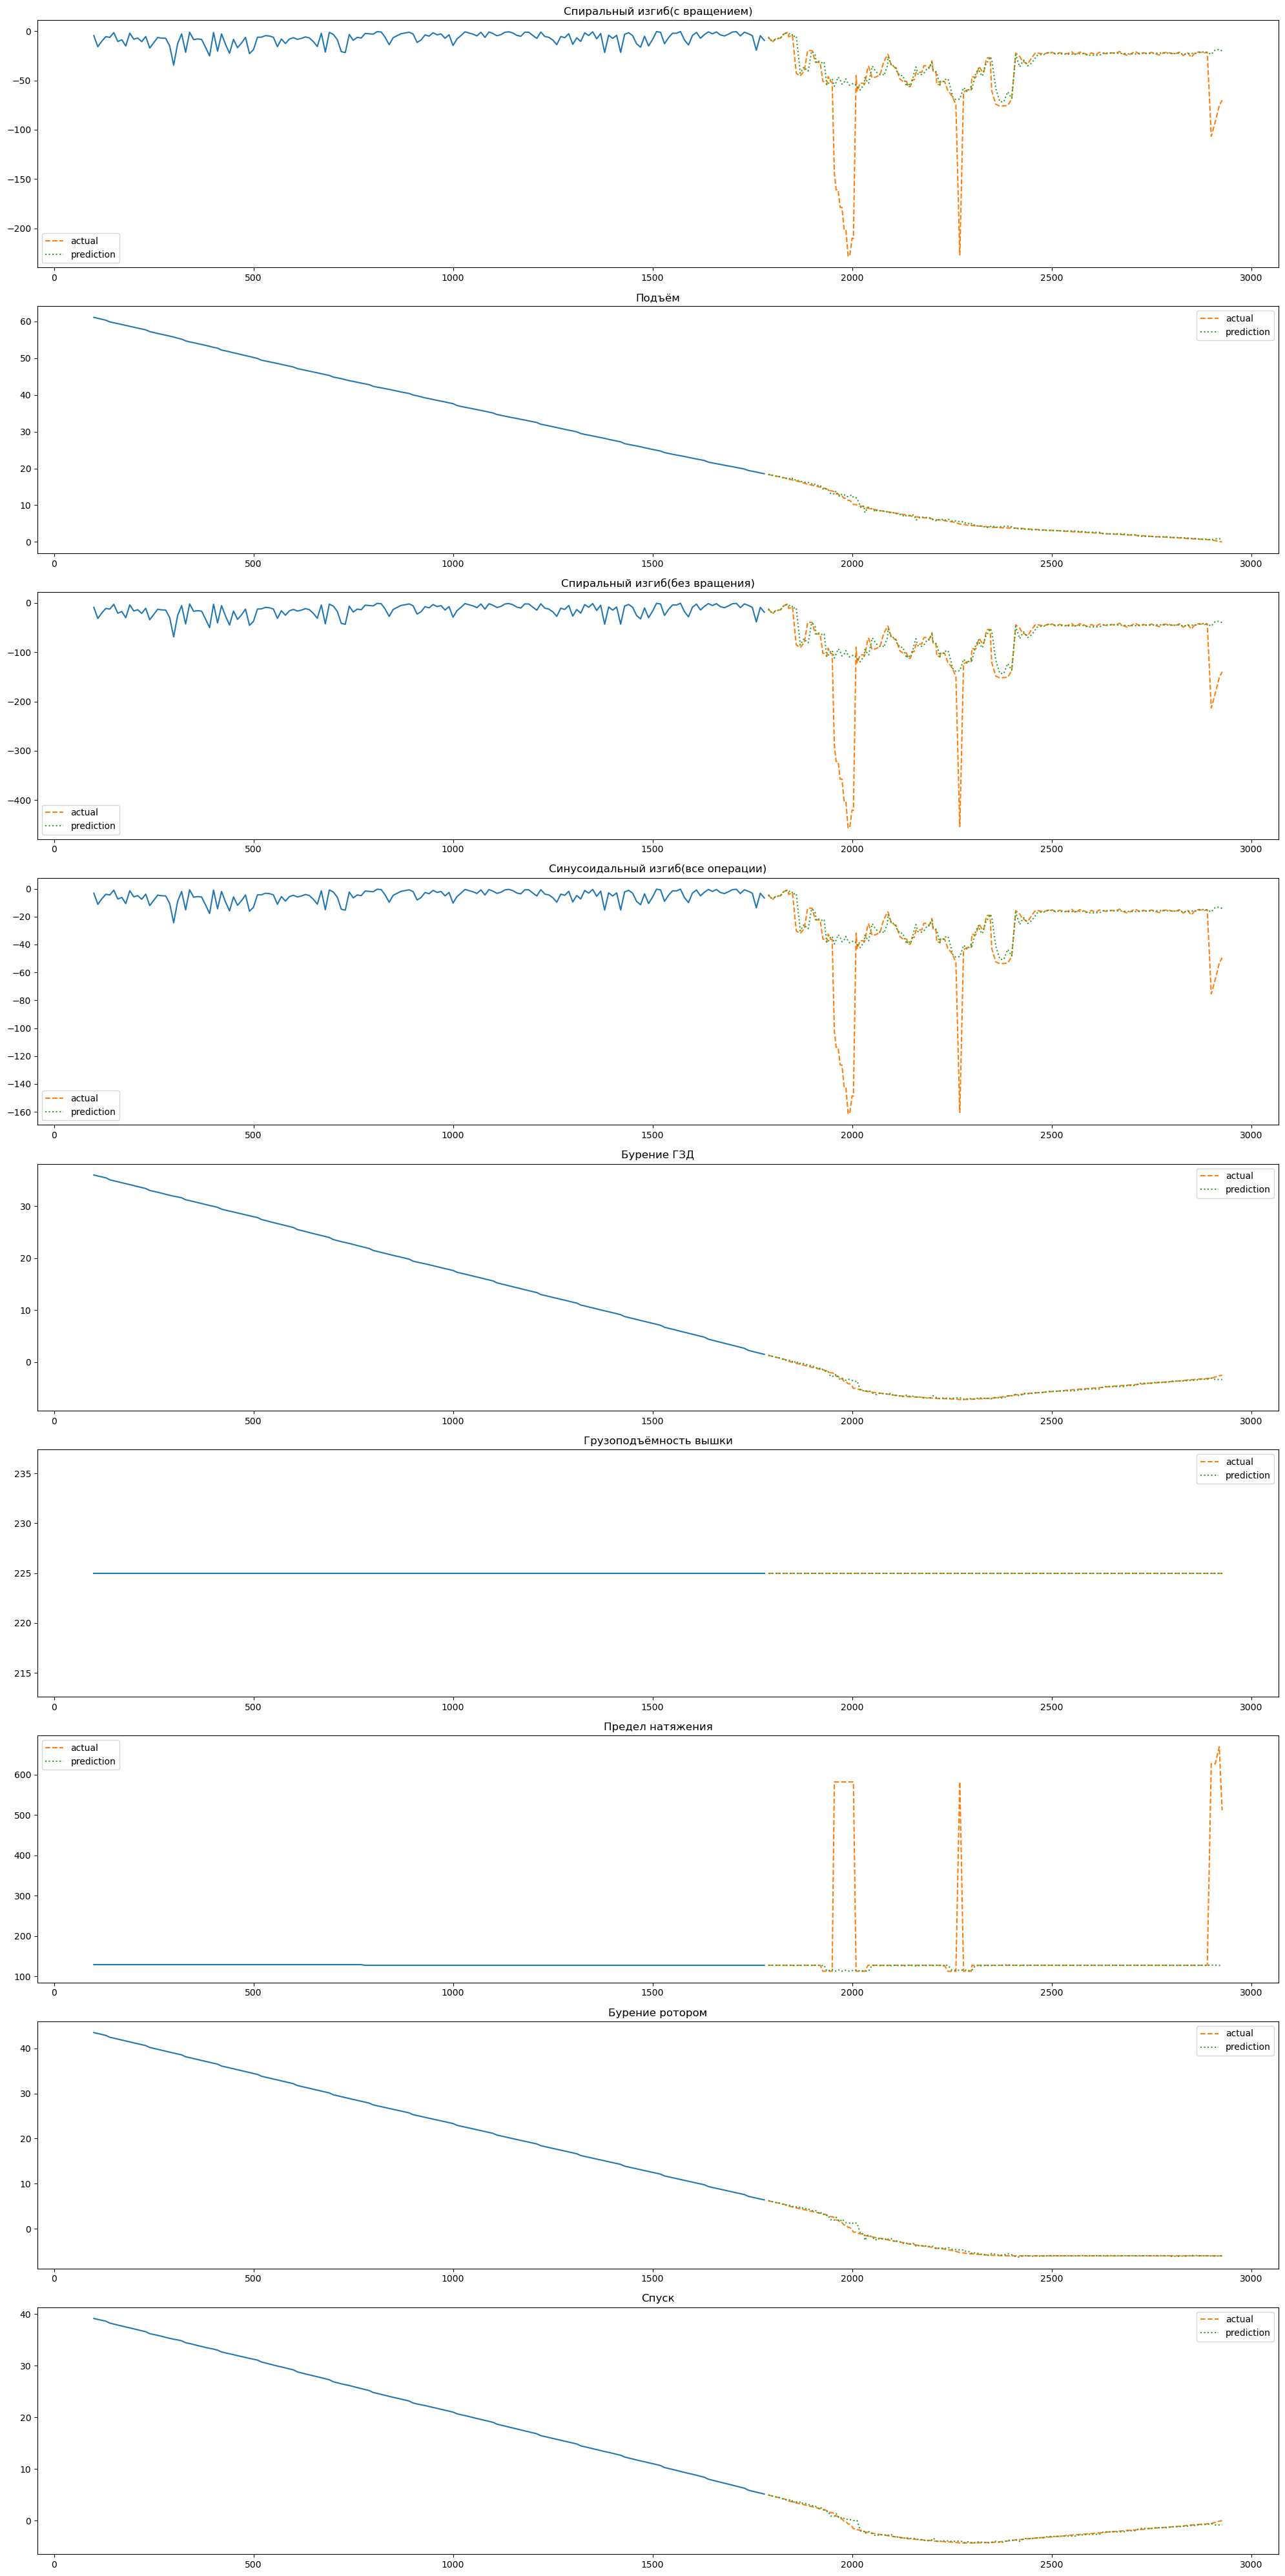

In [385]:
fig, ax = plt.subplots(len(target_cols), figsize=(20, 40))
for i, col in enumerate(target_cols):
    ax[i].set_title(col)
    ax[i].plot(X_train["MD"], y_train[col])
    ax[i].plot(X_test["MD"], y_test[col], label="actual",  linestyle='--')
    ax[i].plot(X_test["MD"], predictions_df[col], label="prediction", linestyle=':')
    ax[i].legend() 
plt.tight_layout()
plt.show()

In [386]:
y_test = y_test.reset_index().drop("index", axis=1)
mape = (abs(y_test - predictions_df) / (abs(y_test)+1e-8)).mean() * 100

print("MAPE Error in percents per column")
print(mape.to_frame())

MAPE Error in percents per column
                                               0
Бурение ГЗД                         1.921091e+01
Бурение ротором                     1.813552e+01
Глубина по вертикали                         NaN
Грузоподъёмность вышки              0.000000e+00
Подъём                              4.770085e+07
Предел натяжения                    8.860847e+00
Синусоидальный изгиб(все операции)  1.893463e+01
Спиральный изгиб(без вращения)      1.892709e+01
Спиральный изгиб(с вращением)       1.892751e+01
Спуск                               4.848653e+07


['Спиральный изгиб(с вращением)', 'Подъём', 'Спиральный изгиб(без вращения)', 'Синусоидальный изгиб(все операции)', 'Бурение ГЗД', 'Грузоподъёмность вышки', 'Предел натяжения', 'Бурение ротором', 'Спуск']


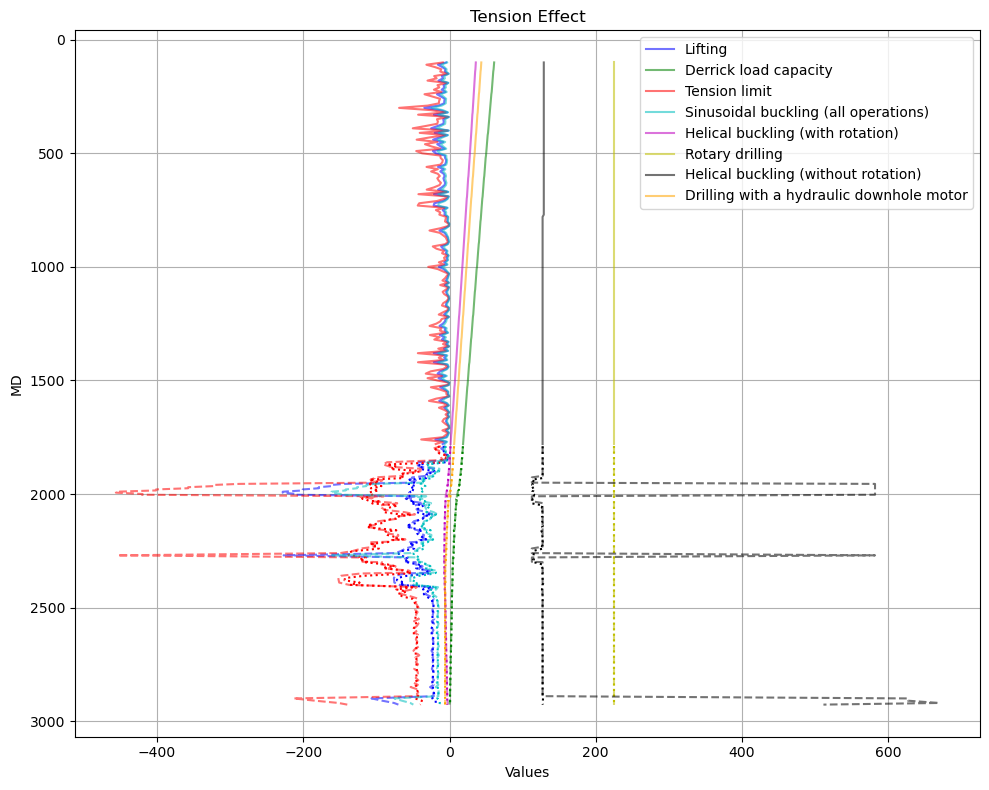

In [388]:
# Перевод target_cols на английский
target_cols_eng = ['Lifting', 'Derrick load capacity', 'Tension limit', 'Sinusoidal buckling (all operations)', 
                   'Helical buckling (with rotation)', 'Rotary drilling', 'Helical buckling (without rotation)', 
                   'Drilling with a hydraulic downhole motor', 'Descent']

plt.figure(figsize=(10, 8))  # Set the figure size
color_list = ['b', 'g', 'r', 'c', 'm', 'y', 'k', '#FFA500']

for color, col_id in zip(color_list, range(len(target_cols))):
    col = target_cols[col_id]
    label = target_cols_eng[col_id]
    plt.plot(y_train[col], X_train["MD"], label=label, color=color, alpha=0.55)
    plt.plot(y_test[col], X_test["MD"], color=color, alpha=0.55, linestyle = '--')
    plt.plot(predictions_df[col], X_test["MD"], color=color, alpha=1.0, linestyle = ':')

print(target_cols)
# ['Подъём', 'Грузоподъёмность вышки', 'Предел натяжения', 'Синусоидальный изгиб(все операции)', 
# 'Спиральный изгиб(с вращением)', 'Бурение ротором', 'Спиральный изгиб(без вращения)', 
# 'Бурение ГЗД', 'Спуск']

# Add labels and title
plt.xlabel('Values')
plt.ylabel('MD')
plt.title('Tension Effect')

# Add legend
plt.legend()
plt.gca().invert_yaxis()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()


## Минимальный вес на долоте

In [389]:
Y_ves = pd.read_csv("../data/preprocessed/aktobe120/aktobe120_Y_min_ves.csv")
Y_ves = Y_ves.rename({"Измеренная глубина рейса" : "MD"}, axis=1)
# Y_ves["MD"] = Y_ves["MD"].str.replace(",", "").astype(float)
Y_ves.head(5)

,MD,Мин. вес на долоте до синусоидального изгиба (бурение ротором),Мин. вес на долоте до спирального изгиба (бурение ротором),Мин. вес на долоте до синусоидального изгиба (бурение ГЗД),Мин. вес на долоте до спирального изгиба (бурение ГЗД)
0,2359,8.55,9.32,4.71,5.56
1,2409,7.31,7.57,3.10,3.86
2,2459,7.12,7.32,2.72,3.29
3,2509,7.49,7.72,2.61,3.26
4,2559,8.98,9.33,3.46,4.48


In [390]:
target_cols = list(set(Y_ves.columns) - set(["MD"]))
Y_ves.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 5 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   MD                                                              13 non-null     int64  
 1   Мин. вес на долоте до синусоидального изгиба (бурение ротором)  13 non-null     float64
 2   Мин. вес на долоте до спирального изгиба (бурение ротором)      13 non-null     float64
 3   Мин. вес на долоте до синусоидального изгиба (бурение ГЗД)      13 non-null     float64
 4   Мин. вес на долоте до спирального изгиба (бурение ГЗД)          13 non-null     float64
dtypes: float64(4), int64(1)
memory usage: 652.0 bytes


In [391]:
X_ves = X[(X["MD"] >= Y_ves["MD"].min()) & (X["MD"] <= Y_ves["MD"].max())]
X_ves.head()

,MD,Incl.,Azim.,Sub-Sea,TVD,Local N Coord,Local E Coord,Global N Coord,Global E Coord,Dogleg,Vertical Section,Body_OD,Body_ID,Body_AvgJointLength,Stabilizer_Length,Stabilizer_OD,Stabilizer_ID,Weight,Coefficient of Friction,Minimum Yield Stress
279,2360.0,79.072,19.082,2237.354,2219.986,265.024,99.122,5089719.524,9691522.812,5.0,282.94,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
280,2370.0,80.699,18.712,2239.110,2221.742,274.338,102.310,5089728.838,9691526.000,5.0,292.79,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
281,2380.0,82.326,18.346,2240.586,2223.218,283.716,105.453,5089738.216,9691529.143,5.0,302.67,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
282,2390.0,83.953,17.982,2241.781,2224.412,293.149,108.548,5089747.649,9691532.238,5.0,312.60,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105
283,2400.0,85.580,17.621,2242.693,2225.325,302.630,111.592,5089757.130,9691535.282,5.0,322.55,88.9,66.09,9.144,0.469,119.86,53.98,25.12,0.3,105


In [392]:
Y_ves["MD"] = Y_ves["MD"].astype(int)
X_ves["MD"] = X_ves["MD"].astype(int)

df = pd.merge_asof(X_ves, Y_ves, on="MD", direction="nearest")
df.head()

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_16480\1737649771.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_ves["MD"] = X_ves["MD"].astype(int)


,MD,Incl.,Azim.,Sub-Sea,TVD,Local N Coord,Local E Coord,Global N Coord,Global E Coord,Dogleg,...,Stabilizer_Length,Stabilizer_OD,Stabilizer_ID,Weight,Coefficient of Friction,Minimum Yield Stress,Мин. вес на долоте до синусоидального изгиба (бурение ротором),Мин. вес на долоте до спирального изгиба (бурение ротором),Мин. вес на долоте до синусоидального изгиба (бурение ГЗД),Мин. вес на долоте до спирального изгиба (бурение ГЗД)
0,2360,79.072,19.082,2237.354,2219.986,265.024,99.122,5089719.524,9691522.812,5.0,...,0.469,119.86,53.98,25.12,0.3,105,8.55,9.32,4.71,5.56
1,2370,80.699,18.712,2239.110,2221.742,274.338,102.310,5089728.838,9691526.000,5.0,...,0.469,119.86,53.98,25.12,0.3,105,8.55,9.32,4.71,5.56
2,2380,82.326,18.346,2240.586,2223.218,283.716,105.453,5089738.216,9691529.143,5.0,...,0.469,119.86,53.98,25.12,0.3,105,8.55,9.32,4.71,5.56
3,2390,83.953,17.982,2241.781,2224.412,293.149,108.548,5089747.649,9691532.238,5.0,...,0.469,119.86,53.98,25.12,0.3,105,7.31,7.57,3.10,3.86
4,2400,85.580,17.621,2242.693,2225.325,302.630,111.592,5089757.130,9691535.282,5.0,...,0.469,119.86,53.98,25.12,0.3,105,7.31,7.57,3.10,3.86


In [393]:
y_full = df[target_cols]
X_full = df.drop(target_cols, axis=1).fillna(method="ffill")
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full,test_size= 0.5,shuffle=False)
X_train.shape, X_test.shape

((30, 20), (30, 20))

In [394]:
# Apply feature engineering to both training and test data
X_test = add_features(X_test)

# Load the saved model and scalers for 'ves_na_kru'
model_path = './model_min_ves.joblib'
x_scaler_path = './x_scaler_min_ves.joblib'
y_scaler_path = './y_scaler_min_ves.joblib'

model = joblib.load(model_path)
x_scaler = joblib.load(x_scaler_path)
y_scaler = joblib.load(y_scaler_path)

# Scale the test data
X_test_scaled = x_scaler.transform(X_test)

# Make predictions and calculate WMAPE
predictions_df = pd.DataFrame(y_scaler.inverse_transform(model.predict(X_test_scaled)), columns=y_test.columns)

1/1 [==============================] - 0s 79ms/step


In [395]:
predictions_df

,Мин. вес на долоте до спирального изгиба (бурение ГЗД),Мин. вес на долоте до синусоидального изгиба (бурение ротором),Мин. вес на долоте до синусоидального изгиба (бурение ГЗД),Мин. вес на долоте до спирального изгиба (бурение ротором)
0,3.993730,8.997611,3.018757,9.346515
1,3.978466,8.969242,3.042305,9.301036
2,3.631794,8.801712,2.702786,9.142504
3,3.528584,8.777797,2.675584,9.089592
4,3.528584,8.777797,2.675584,9.089592
5,3.432211,8.768188,2.636664,9.063868
6,3.272829,8.753479,2.577270,9.014217
7,3.163481,8.787904,2.517011,9.033092
8,3.110822,8.788559,2.559531,8.998697
9,2.727486,8.726381,2.272014,8.893414


In [396]:
y_test

,Мин. вес на долоте до спирального изгиба (бурение ГЗД),Мин. вес на долоте до синусоидального изгиба (бурение ротором),Мин. вес на долоте до синусоидального изгиба (бурение ГЗД),Мин. вес на долоте до спирального изгиба (бурение ротором)
30,3.67,8.80,2.66,9.15
31,3.67,8.80,2.66,9.15
32,3.67,8.80,2.66,9.15
33,3.67,8.80,2.66,9.15
34,3.67,8.80,2.66,9.15
35,2.98,8.72,2.25,8.97
36,2.98,8.72,2.25,8.97
37,2.98,8.72,2.25,8.97
38,2.98,8.72,2.25,8.97
39,2.98,8.72,2.25,8.97


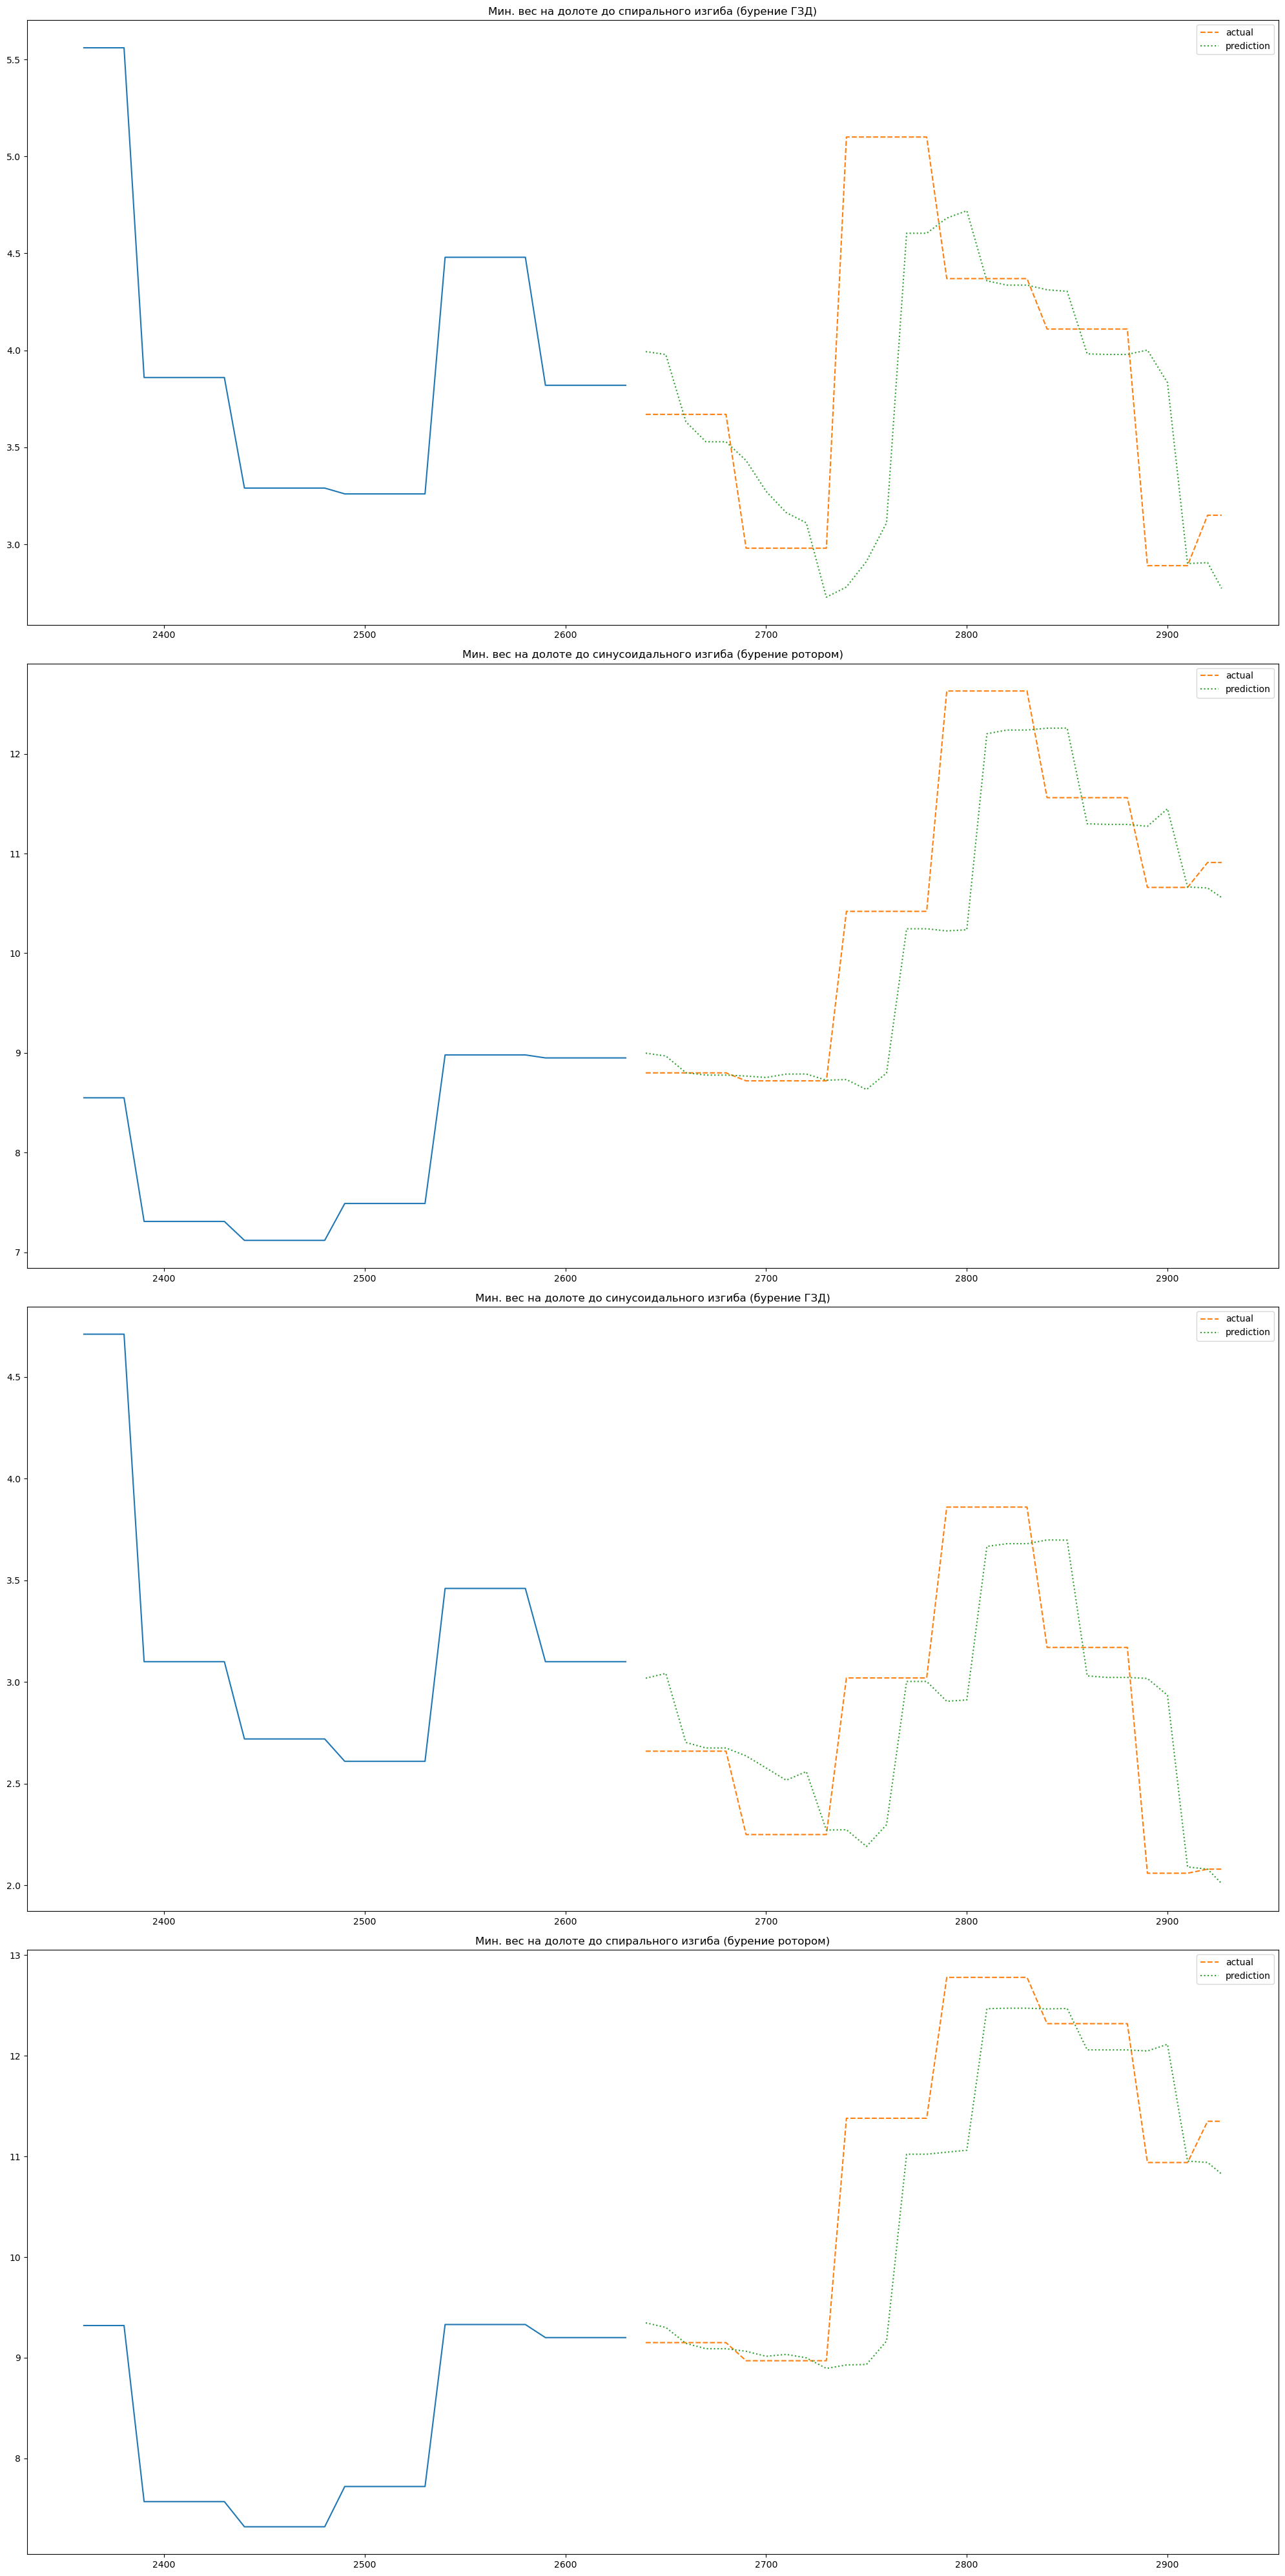

In [397]:
fig, ax = plt.subplots(len(target_cols), figsize=(20, 40))
for i, col in enumerate(target_cols):
    ax[i].set_title(col)
    ax[i].plot(X_train["MD"], y_train[col])
    ax[i].plot(X_test["MD"], y_test[col], label="actual",  linestyle='--')
    ax[i].plot(X_test["MD"], predictions_df[col], label="prediction", linestyle=':')
    ax[i].legend() 
plt.tight_layout()
plt.show()

In [398]:
y_test = y_test.reset_index().drop("index", axis=1)
mape = (abs(y_test - predictions_df) / (abs(y_test)+1e-8)).mean() * 100

print("MAPE Error in percents per column")
print(mape.to_frame())

MAPE Error in percents per column
                                                            0
Мин. вес на долоте до спирального изгиба (бурен...  11.472304
Мин. вес на долоте до синусоидального изгиба (б...   4.828772
Мин. вес на долоте до синусоидального изгиба (б...  12.355454
Мин. вес на долоте до спирального изгиба (бурен...   4.988975


['Мин. вес на долоте до спирального изгиба (бурение ГЗД)', 'Мин. вес на долоте до синусоидального изгиба (бурение ротором)', 'Мин. вес на долоте до синусоидального изгиба (бурение ГЗД)', 'Мин. вес на долоте до спирального изгиба (бурение ротором)']


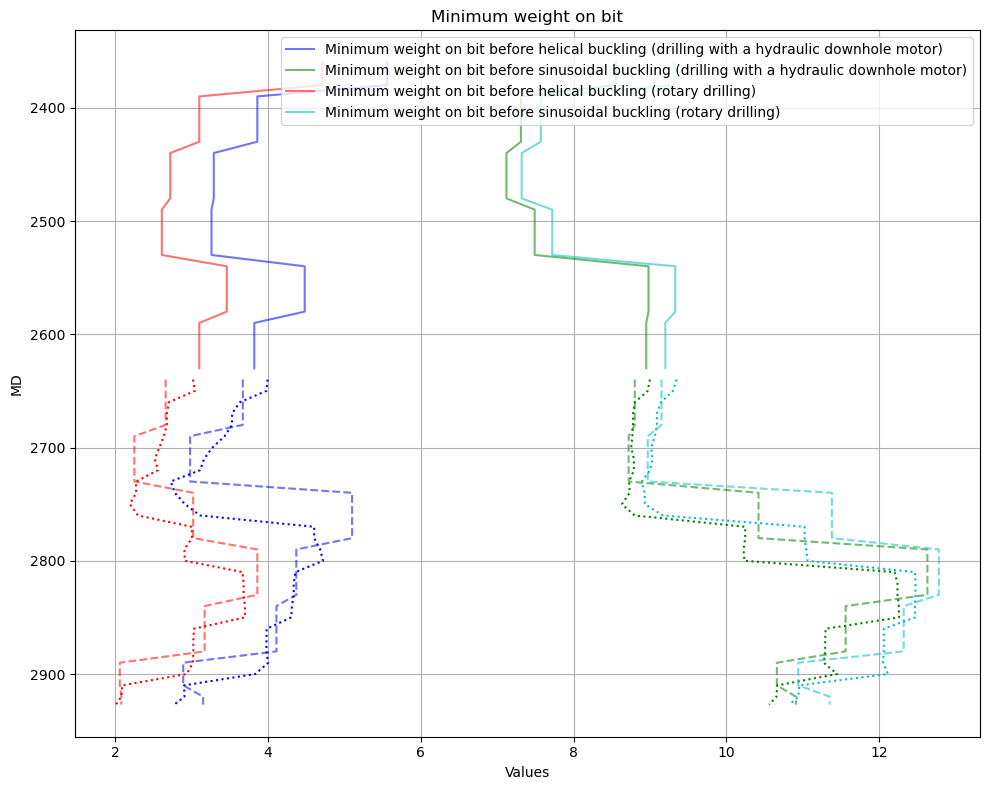

In [399]:
# Перевод target_cols на английский
target_cols_eng = ['Minimum weight on bit before helical buckling (drilling with a hydraulic downhole motor)', 
                   'Minimum weight on bit before sinusoidal buckling (drilling with a hydraulic downhole motor)', 
                   'Minimum weight on bit before helical buckling (rotary drilling)', 
                   'Minimum weight on bit before sinusoidal buckling (rotary drilling)']

plt.figure(figsize=(10, 8))  # Set the figure size
color_list = ['b', 'g', 'r', 'c']

for color, col_id in zip(color_list, range(len(target_cols))):
    col = target_cols[col_id]
    label = target_cols_eng[col_id]
    plt.plot(y_train[col], X_train["MD"], label=label, color=color, alpha=0.55)
    plt.plot(y_test[col], X_test["MD"], color=color, alpha=0.55, linestyle = '--')
    plt.plot(predictions_df[col], X_test["MD"], color=color, alpha=1.0, linestyle = ':')

print(target_cols)
# ['Мин. вес на долоте до спирального изгиба (бурение ГЗД)', 
#  'Мин. вес на долоте до синусоидального изгиба (бурение ГЗД)', 
#  'Мин. вес на долоте до спирального изгиба (бурение ротором)', 
#  'Мин. вес на долоте до синусоидального изгиба (бурение ротором)']

# Add labels and title
plt.xlabel('Values')
plt.ylabel('MD')
plt.title('Minimum weight on bit')

# Add legend
plt.legend()
plt.gca().invert_yaxis()

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()
